# Timeseries Analysis
This notebook contains all of the code needed to run the analysis for the timeseries project. The code is broken up into sections, each of which is described below.

In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean
import csv
import matplotlib
import matplotlib.animation as animation
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from global_land_mask import globe
import xcdat as xc

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
styles = ["-", "--", "-.", ":", "-"]
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = [15, 10]
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", linewidth=4)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.Paired.colors)
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
colors = ['#d1e5f0','#67a9cf','#2166ac', '#fddbc7', '#ef8a62', '#b2182b']
# colors = ['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
# colors = ['#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
figlabels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]

TIME_RANGE = slice("2016-01-01", "2023-08-31")
START_DATE = "2016-01-01"
END_DATE = "2023-08-31"
LEGEND_LABELS = ['_', '_', "Ross", "Amundsen (AM)", "Bellingshausen (BS)", "Weddell (WE)", "South Indian (SI)", "South West Pacific (SWP)"]
SI_METRIC = 'sia' # 'sia'
SI_METRIC_LABEL = 'Sea Ice Area' #'Sea Ice Area'

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(
ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/zespinosa/conda-envs/cenv/share/proj failed


In [77]:
si_cesm2_enso = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/enso_si_CESM_SH_anoms.nc")
si_regions_cesm2_enso = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/enso_si_regions_CESM_anoms.nc")

si_nsidc = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_NSIDC_SH_anoms.nc")
si_cesm2 = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_CESM_SH_si-anoms.nc")

si_nsidc_raw = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_NSIDC_SH.nc")
si_cesm2_raw = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_CESM_SH_si.nc")

si_regions_nsidc = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_regions_NSIDC_anoms.nc")
si_regions_cesm2 = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_regions_CESM_anoms.nc")

print(si_nsidc)

<xarray.Dataset>
Dimensions:  (time: 537)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-09-01
Data variables:
    sia      (time) float64 ...
    sie      (time) float64 ...


# Figure S1

## timeseries

In [78]:
from scipy.stats import linregress

# si_nsidc["sia"][107] = np.nan
# si_nsidc["sia"][108] = np.nan
# si_nsidc["sie"][107] = np.nan
# si_nsidc["sie"][108] = np.nan

# Get seasons
si_nsidc_sia = si_nsidc["sia"].sel(time=slice("1979-01", "2023-08"))
print(si_nsidc_sia)
si_cesm2_sia = si_cesm2["sia"].sel(time=slice("1979-01", "2023-08"))
si_cesm2_sia = si_cesm2_sia[~np.isnan(si_nsidc_sia.values)]
si_nsidc_sia = si_nsidc_sia[~np.isnan(si_nsidc_sia.values)]

si_nsidc_djf = si_nsidc_sia.sel(time=si_nsidc_sia["time.season"] == "DJF")
si_nsidc_mam = si_nsidc_sia.sel(time=si_nsidc_sia["time.season"] == "MAM")
si_nsidc_jja = si_nsidc_sia.sel(time=si_nsidc_sia["time.season"] == "JJA")
si_nsidc_son = si_nsidc_sia.sel(time=si_nsidc_sia["time.season"] == "SON")

si_cesm2_djf = si_cesm2_sia.sel(time=si_cesm2_sia["time.season"] == "DJF")
si_cesm2_mam = si_cesm2_sia.sel(time=si_cesm2_sia["time.season"] == "MAM")
si_cesm2_jja = si_cesm2_sia.sel(time=si_cesm2_sia["time.season"] == "JJA")
si_cesm2_son = si_cesm2_sia.sel(time=si_cesm2_sia["time.season"] == "SON")

# Regression for each season
res_djf = linregress(si_cesm2_djf, si_nsidc_djf)
res_mam = linregress(si_cesm2_mam, si_nsidc_mam)
res_jja = linregress(si_cesm2_jja, si_nsidc_jja)
res_son = linregress(si_cesm2_son, si_nsidc_son)

# Print each
print("DJF: ", res_djf)
print("MAM: ", res_mam)
print("JJA: ", res_jja)
print("SON: ", res_son)

<xarray.DataArray 'sia' (time: 536)>
array([ 0.259761,  0.125523, -0.087965, ..., -2.138498, -2.386814, -2.136256])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-08-01
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True
DJF:  LinregressResult(slope=0.8659797538241085, intercept=-0.025933026478564186, rvalue=0.5953415278880417, pvalue=5.126431365647772e-14, stderr=0.10250405320606427, intercept_stderr=0.03961989959442617)
MAM:  LinregressResult(slope=0.6150639678678712, intercept=-0.002517924961341192, rvalue=0.4542367739436002, pvalue=3.1356488653977505e-08, stderr=0.10460004474059509, intercept_stderr=0.04797257119897585)
JJA:  LinregressResult(slope=0.573321887088398, intercept=0.008189113464946399, rvalue=0.5524746172188749, pvalue=3.735504466042034e-12, stderr=0.07500348825549158, intercept_stderr=0.04208665837386506)
SON:  LinregressResult(slope=0.5216894885930395, intercept=0.0033026418275

2024-02-02 17:04:33,026 [WARNING]: legend.py(_parse_legend_args:1217) >> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


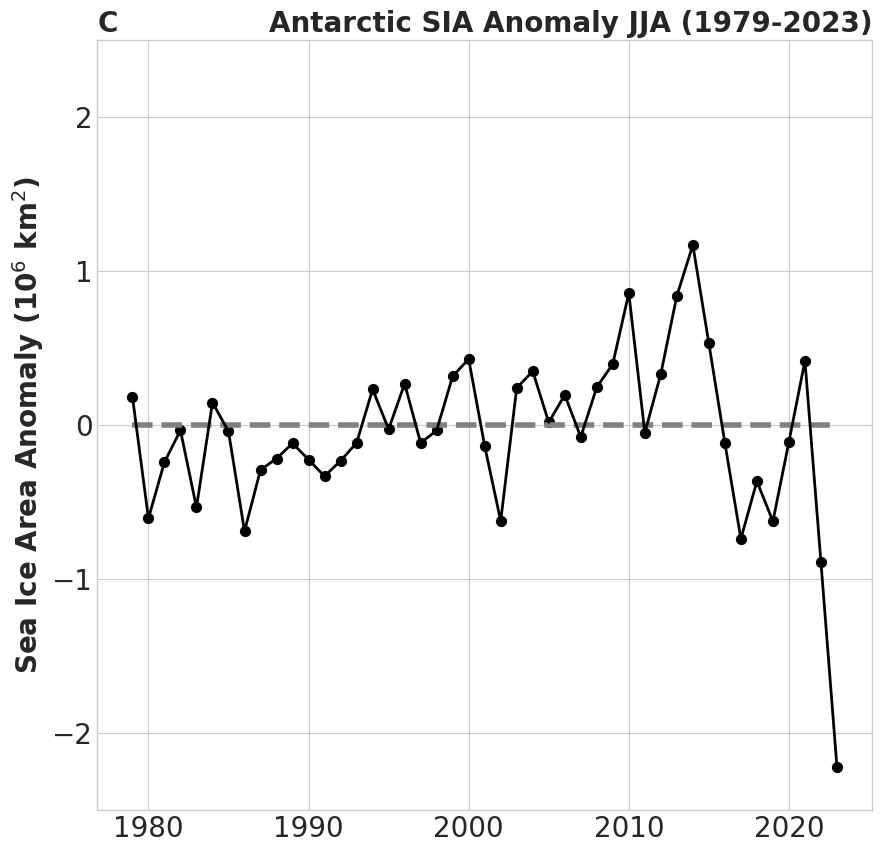

In [79]:
def plot_JJA_timeseries():
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    s = si_nsidc_jja.groupby("time.year").mean()
    ax.hlines(0, s.year[0], s.year[-1], color="gray", linestyle="--")
    ax.plot(s.year, s, color="black", linewidth=2)
    ax.scatter(s.year, s, color="black", s=50)

    ax.set_title("C", loc="left", fontweight="bold")
    ax.set_title(f"Antarctic SIA Anomaly JJA (1979-2023)", loc="right", fontweight="bold")
    ax.set_ylabel(f"{SI_METRIC_LABEL} Anomaly (10$^6$ km$^2$)", fontweight="bold")
    ax.set_ylim(-2.5, 2.5)
    ax.legend()
    plt.savefig("figures/Figure_SX_JAS_SI.png", dpi=400)

plot_JJA_timeseries()
    

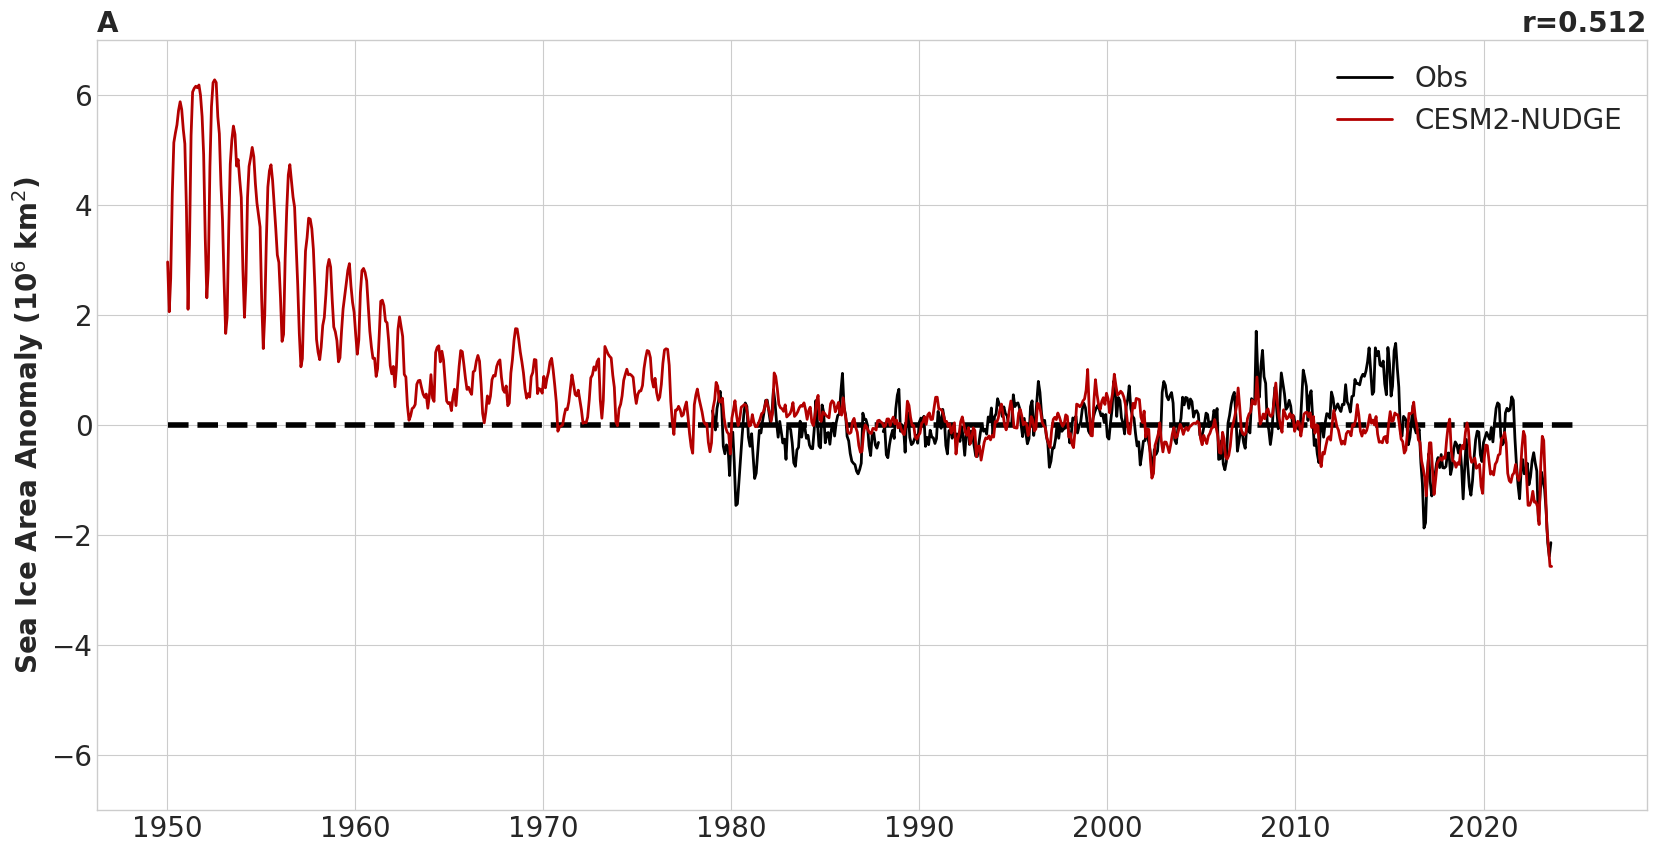

In [80]:
def plot_drift():
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    ax.hlines(0, si_cesm2.time[0], si_cesm2.time[-1], color="black", linestyle="--")

    si_cesm2_sia = si_cesm2[SI_METRIC].sel(time=slice("1950-01", "2023-08"))
    si_nsidc_sia = si_nsidc[SI_METRIC].sel(time=slice("1979-01", "2023-08"))

    ax.plot(si_nsidc_sia.time, si_nsidc_sia, color="black", label="Obs", linewidth=2)
    ax.plot(si_cesm2_sia.time, si_cesm2_sia, color="#b30000", label="CESM2-NUDGE", linewidth=2)

    # Regression
    si_cesm2_sia = si_cesm2_sia.sel(time=slice("1979-01", "2023-08"))
    si_cesm2_sia = si_cesm2_sia[~np.isnan(si_nsidc_sia.values)]
    si_nsidc_sia = si_nsidc_sia[~np.isnan(si_nsidc_sia.values)]
    res = linregress(si_cesm2_sia.values, si_nsidc_sia.values)

    ax.set_title("A", loc="left", fontweight="bold")
    ax.set_title(f"r={np.around(res.rvalue, 3)}", loc="right", fontweight="bold")
    ax.set_ylabel(f"{SI_METRIC_LABEL} Anomaly (10$^6$ km$^2$)", fontweight="bold")
    ax.set_ylim(-7, 7)
    ax.legend()
    plt.savefig("figures/Figure_SX_SI_drift.png", dpi=400)

plot_drift()

## Annual Cycle

In [81]:
from scipy.stats import linregress

# si_nsidc_raw["sia"][107] = np.nan
# si_nsidc_raw["sia"][108] = np.nan
# si_nsidc_raw["sie"][107] = np.nan
# si_nsidc_raw["sie"][108] = np.nan

# Get seasons
si_nsidc_sia_raw = si_nsidc_raw[SI_METRIC].sel(time=slice("1979-01", "2023-08"))
si_cesm2_sia_raw = si_cesm2_raw[SI_METRIC].sel(time=slice("1979-01", "2023-08"))

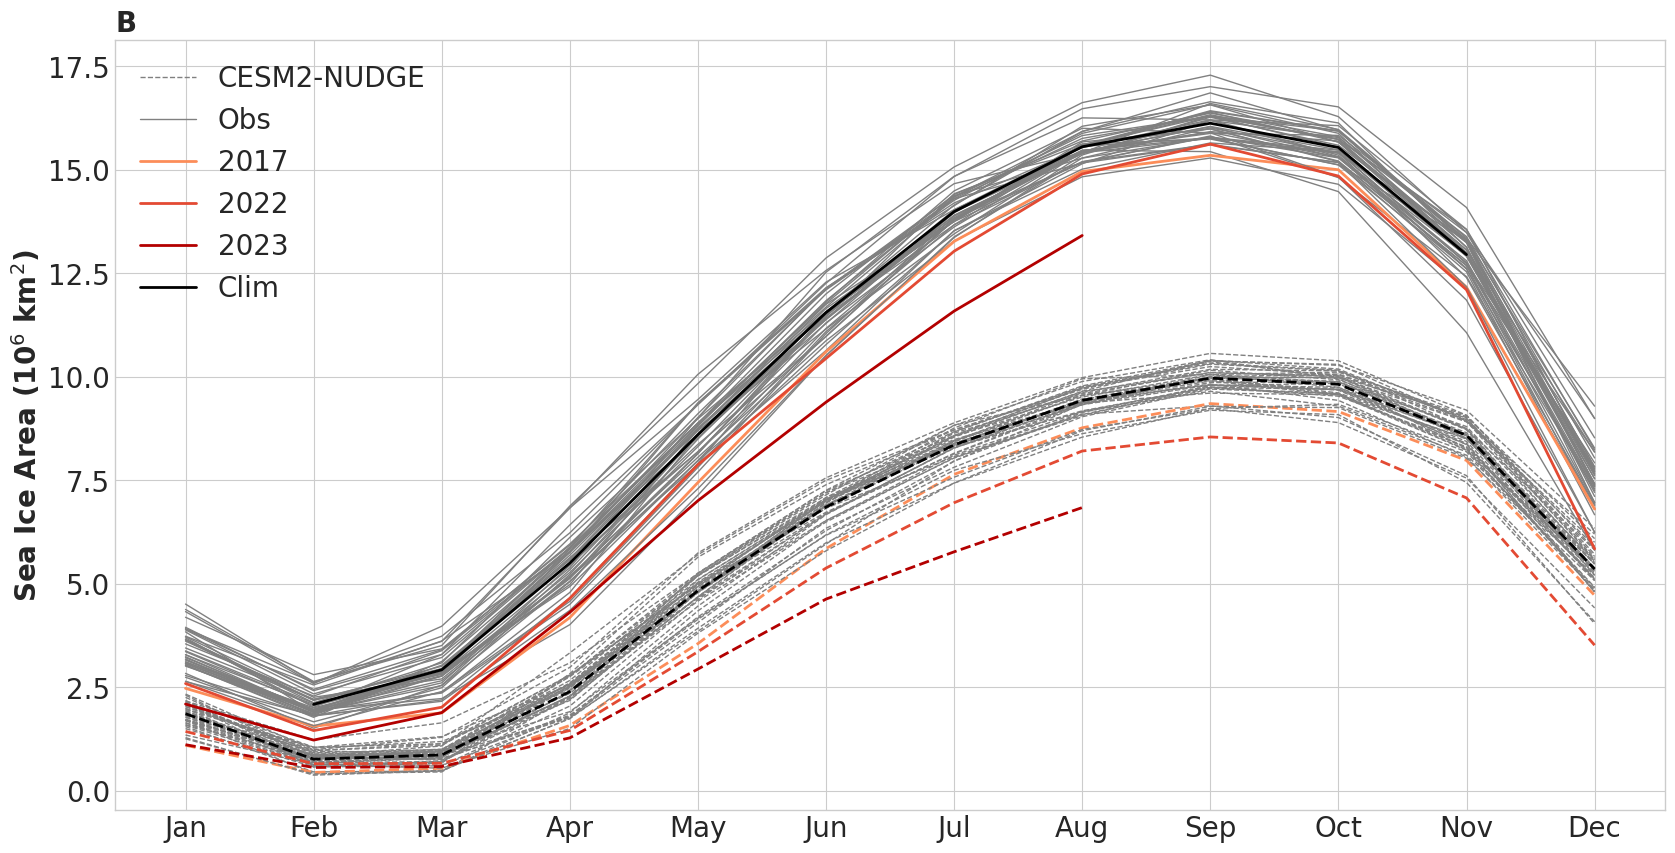

In [82]:
colors = ['#fc8d59','#e34a33','#b30000']

# Plotting Time Series
start_time, end_time = "1979-01-01", "2023-08-01"
time = np.arange(start_time, "2024-01-01", dtype="datetime64[M]")

# Create dataarray of NaNs with dim time and coordinates 2023-09-01 to 2024-01-01
nans = xr.DataArray(np.full((4,), np.nan), coords=[time[-4:]], dims=["time"])
cesm2_full = xr.concat([si_cesm2_sia_raw,nans], dim="time")
nsidc_full = xr.concat([si_nsidc_sia_raw,nans], dim="time")

# Reshape nsidc from time to year, month
ntime = int(cesm2_full.time.shape[0]/12)
cesm2_year = cesm2_full.values.reshape((ntime, 12))
nsidc_year = nsidc_full.values.reshape((ntime, 12))
for yr in range(ntime):
    cyear = 1979 + yr 
    if cyear == 2017:
        plt.plot(np.arange(12), cesm2_year[yr,:], linewidth=2, color=colors[0], linestyle="dashed")
        plt.plot(np.arange(12), nsidc_year[yr,:], linewidth=2, color=colors[0], label="2017")
    elif cyear == 2022:
        plt.plot(np.arange(12), cesm2_year[yr,:], linewidth=2, color=colors[1], linestyle="dashed")
        plt.plot(np.arange(12), nsidc_year[yr,:], linewidth=2, color=colors[1], label="2022")
    elif cyear == 2023:
        plt.plot(np.arange(12), cesm2_year[yr,:], linewidth=2, color=colors[2], linestyle="dashed")
        plt.plot(np.arange(12), nsidc_year[yr,:], linewidth=2, color=colors[2], label="2023")
    else:
        if cyear == 1979:
            plt.plot(np.arange(12), cesm2_year[yr,:], linewidth=1, color="gray", linestyle="dashed", label="CESM2-NUDGE")
            plt.plot(np.arange(12), nsidc_year[yr,:], linewidth=1, color="gray", label="Obs")
        else:
            plt.plot(np.arange(12), nsidc_year[yr,:], linewidth=1, color="gray")
            plt.plot(np.arange(12), cesm2_year[yr,:], linewidth=1, color="gray", linestyle="dashed")


# Plot Climatology
clim = 2020 - 1980
plt.plot(np.arange(12), cesm2_year[1:clim].mean(axis=0), linewidth=2, color="black", linestyle="dashed")
plt.plot(np.arange(12), nsidc_year[1:clim].mean(axis=0), linewidth=2, color="black", label="Clim")

plt.ylabel(f"{SI_METRIC_LABEL} (10$^6$ km$^2$)", fontweight="bold")
plt.legend()

fig = plt.gcf()
fig.set_size_inches(20, 10)

# Create list of month strings
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
plt.xticks(np.arange(12), labels=months)
plt.title("B", loc="left", fontweight="bold")
plt.savefig("figures/Figure_SX_SI_Annual_Cycle.png", dpi=400)

## Figure 1 G and H

/glade/derecho/scratch/zespinosa/tmp/ipykernel_13230/2672137184.py:53: UserWarning: The handle <matplotlib.collections.LineCollection object at 0x7f8c55a80d60> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(labels=LEGEND_LABELS, loc='center left', bbox_to_anchor=(1.0, 1.5))
/glade/derecho/scratch/zespinosa/tmp/ipykernel_13230/2672137184.py:53: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8c55a805b0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(labels=LEGEND_LABELS, loc='center left', bbox_to_anchor=(1.0, 1.5))


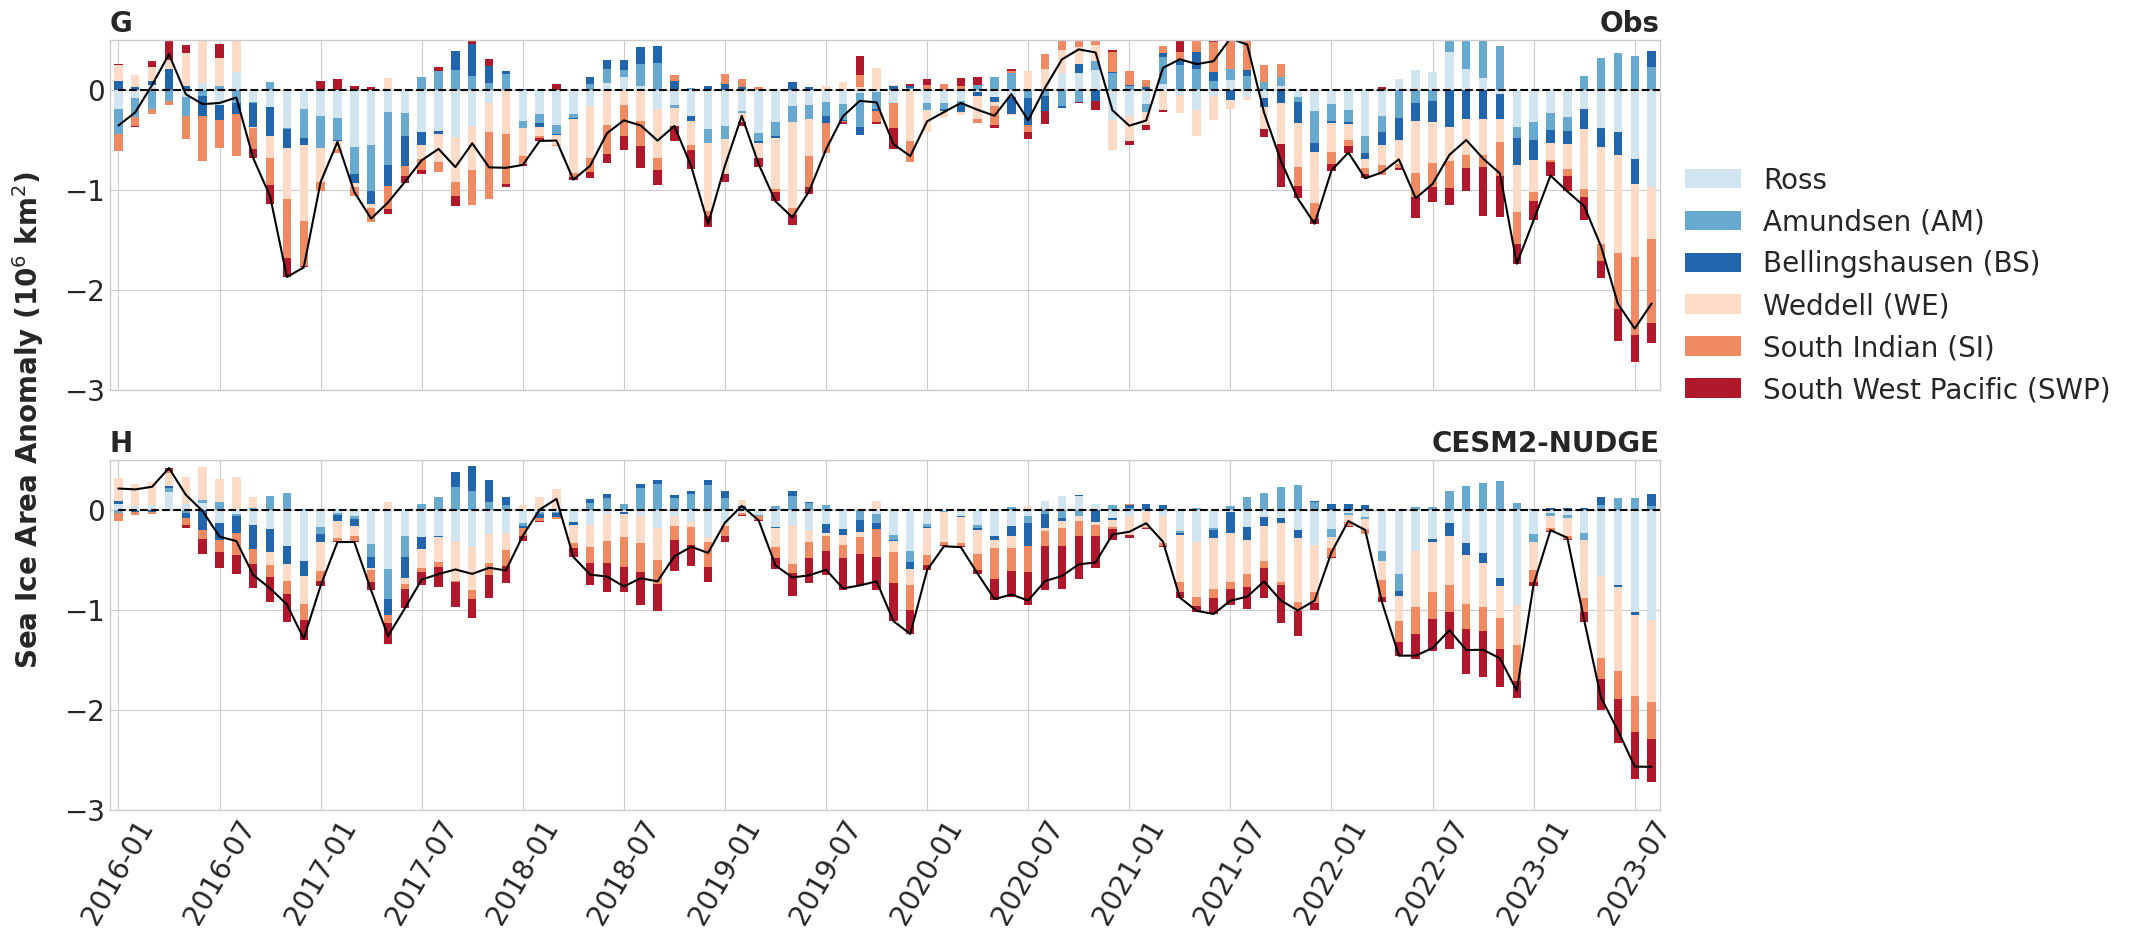

In [75]:
# time_params = {
#     "time_range": slice("2020-01-01", "2023-08-31"),
#     "ticklabels": ["2020-01", "2020-04", "2020-07", "2020-10", "2021-01", "2021-04", "2021-07", "2021-10", "2022-01", "2022-04", "2022-07", "2022-10", "2023-01", "2023-04", "2023-07"],
# }
START_DATE = "2016-01-01"
END_DATE = "2023-08-31"
TIME_STEP = 6
colors = ['#d1e5f0','#67a9cf','#2166ac', '#fddbc7', '#ef8a62', '#b2182b']

time_params = {
    "time_range": slice(START_DATE, END_DATE),
    "ticklabels": np.arange(START_DATE, END_DATE, TIME_STEP, dtype="datetime64[M]"),
}

def timeseries(time_params):
    linewidth = 1.5
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)
    # Plot Line for NSIDC
    sia_nsidc = si_nsidc[SI_METRIC].sel(time=time_params["time_range"])
    ax1.hlines(0, xmin=0, xmax=len(sia_nsidc), color="black", linewidth=linewidth, linestyle="dashed")
    ax1.plot(sia_nsidc, color="black", linewidth=linewidth,)
    # Plot Line for CESM2-NUDGE
    sia_cesm2= si_cesm2[SI_METRIC].sel(time=time_params["time_range"])
    ax2.hlines(0, xmin=0, xmax=len(sia_cesm2), color="black", linewidth=linewidth, linestyle="dashed")
    ax2.plot(sia_cesm2, color="black", linewidth=linewidth,)

    # Plot Bar Charts for NSIDC
    sia_regions_nsidc = si_regions_nsidc[SI_METRIC].sel(time=time_params["time_range"])
    sia_regions_nsidc.to_pandas().T.plot.bar(ax=ax1, stacked=True, legend=False, color=colors)

    # Plot Bar Charts for CESM2-NUDGE
    sia_regions_cesm2 = si_regions_cesm2[SI_METRIC].sel(time=time_params["time_range"])
    sia_regions_cesm2.to_pandas().T.plot.bar(ax=ax2, stacked=True, legend=False, color=colors)


    # Add Styling
    ax2.set_xticks(np.arange(0, len(sia_nsidc), TIME_STEP))
    ax2.set_xticklabels(time_params["ticklabels"], rotation=60)

    ax1.set_title(loc="right", label="Obs", fontweight="bold")
    ax1.set_title(loc="left", label="G", fontweight="bold")

    ax2.set_title(loc="right", label="CESM2-NUDGE", fontweight="bold")
    ax2.set_title(loc="left", label="H", fontweight="bold")

    ax1.set_ylim(-3, .5)
    ax2.set_ylim(-3, .5)
    
    ax2.set_xlabel("")
    # Share ylabel for both ax1 and ax2
    fig.text(.075, 0.5, f"{SI_METRIC_LABEL} Anomaly (10$^6$ km$^2$)", va="center", rotation="vertical", fontweight="bold")

    plt.legend(labels=LEGEND_LABELS, loc='center left', bbox_to_anchor=(1.0, 1.5))
    plt.savefig("figures/Figure_1gh.png", dpi=400, bbox_inches='tight')

timeseries(time_params)

# Hovmoller Code

In [83]:
def get_land_sea_mask(ds):
    """
    Creates a land_sea_mask using global_land_mask and ds
    """
    # Swap lon from 0-360 to -180-180 using xarray
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    # Make a grid
    lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
    land_mask = globe.is_land(lat_grid, lon_grid)
    # Create xarray using land_mask
    land_mask = xr.DataArray(land_mask, coords=[ds.lat, ds.lon], dims=["lat", "lon"])
    land_mask = land_mask.rename("land_mask").to_dataset()
    # Add bounds
    land_mask = land_mask.bounds.add_bounds("X")
    land_mask = land_mask.bounds.add_bounds("Y")
    land_mask = xc.swap_lon_axis(land_mask, to=(0, 360))

    return land_mask

def apply_land_mask(ds, land_mask):
    # Set land to nan
    ds = ds.where(land_mask["land_mask"] == 0)

    return ds

In [84]:
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
nsidc_ice_anoms = xr.open_dataset("../data/nsidc_regrid-anoms.nc")

cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")
nsidc_ice_clim = xr.open_dataset("../data/nsidc_regrid-clim.nc")

# Apply Land Mask
cesm2_lsm = get_land_sea_mask(cesm2_ice_anoms)
cesm2_ice_anoms = apply_land_mask(cesm2_ice_anoms, cesm2_lsm)
cesm2_ice_clim = apply_land_mask(cesm2_ice_clim, cesm2_lsm)

nsidc_lsm = get_land_sea_mask(nsidc_ice_anoms)
nsidc_ice_anoms = apply_land_mask(nsidc_ice_anoms, nsidc_lsm)
nsidc_ice_clim = apply_land_mask(nsidc_ice_clim, nsidc_lsm)

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/zespinosa/conda-en

In [85]:
def get_latitude_ice_edge(ice_clim, ice_anoms, test=False): 
    """
    This function gets the latitude of the climatological ice edge, 
    and then calculates the area-weighted sea-ice area anomaly between ice_edge and the pole.
    """
    area_weight_sia_anoms = 0

    ##################### PART 1 ##################### 
    # Get the latitude of the southern most value that is greater than .15 (15%)
    ice_clim = ice_clim.sel(lat=slice(-90, 0))
    ice_anoms = ice_anoms.sel(lat=slice(-90, 0))
    if test: 
        print(ice_clim.isel(lon=1, time=9))
    ice_clim_mask = ice_clim > .15
    
    if test:
        print("Current Latitudes: ", ice_clim_mask.lat)
        print("Mask for single lon:",ice_clim_mask.isel(lon=1, time=9))
        print("Sea Ice Conc for single lon:", ice_clim.isel(lon=1, time=9))

    # Argmax chooses the first value that is True (i.e. 1). 
    # Here we reverse the latitude coordinates so that the first value is the northern most True value (ice edge)
    ice_clim_mask = ice_clim_mask.reindex(lat=list(reversed(ice_clim_mask.lat)))
    ice_clim = ice_clim.reindex(lat=list(reversed(ice_clim.lat)))
    # Take the argmax, which should return the index of the northern most value that is greater than .15
    # If no value exists, it returns -.05N
    lat_idx = ice_clim_mask.argmax(dim="lat")
    # Get the latitude of the ice edge using the index
    ice_edge = ice_clim.lat[lat_idx]
    # Replace -.05N with -89.5N
    ice_edge = ice_edge.where(ice_edge != -0.5, -89.5)

    if test:
        print("Lat index cooresponding to single lon: ", lat_idx.isel(lon=1, time=9).values)
        print("Lat cooresponding to single lon: ", ice_edge.isel(lon=1, time=9).values)

        # Plot the ice edge
        for i in range(12):
            plt.plot(ice_edge.isel(time=i), label=f"Month {i}")
        plt.legend()

    ##################### PART 2 ##################### 
    # concat ice_edge with itself to make it the same shape as ice_anoms
    ntimes = int(ice_anoms.time.shape[0]/12 + ice_anoms.time.shape[0]%12)
    ice_edge = xr.concat([ice_edge]*ntimes, dim="time")[:len(ice_anoms.time)]
    ice_edge["time"] = ice_anoms.time
    
    # At each longitude, get the latitudes less than the ice edge latitude from ice_anoms
    # print(ice_anoms.isel(lon=1, time=9))
    ice_anoms_SofEdge = ice_anoms.where(ice_anoms.lat <= ice_edge, np.nan)
    # print(ice_anoms_SofEdge.isel(lon=1, time=9))
    # Weight by cosine of latitude and take average
    area_weight_sia_anoms = ice_anoms_SofEdge.weighted(np.cos(np.deg2rad(ice_anoms.lat))).mean(dim="lat", skipna=True)
    # replace nan with 0
    area_weight_sia_anoms = area_weight_sia_anoms.fillna(0)


    return area_weight_sia_anoms, ice_edge

## TESTING ##
# TIME_RANGE = slice("2016-01-01", "2023-08-31")

# cesm2_anoms = cesm2_ice_anoms.sel(time=TIME_RANGE)
# area_weight_siCESM2_anoms = get_latitude_ice_edge(
#     ice_clim=cesm2_ice_clim["aice"],
#     ice_anoms=cesm2_anoms["aice"],
#     test=False,
# )

# obs_anoms = nsidc_ice_anoms.sel(time=TIME_RANGE)
# area_weight_siNSIDC_anoms = get_latitude_ice_edge(
#     ice_clim=nsidc_ice_clim["cdr_seaice_conc"],
#     ice_anoms=obs_anoms["cdr_seaice_conc"],
#     test=False
# )

In [86]:
def create_hovmoller(dfs, times, cmap_info, save_info):
    # Create subplot with two axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), sharey=True)
    # Plot contour of SST anomalies
    ax1.contourf(dfs["obs"]["data"].lon, times, dfs["obs"]["data"], cmap=cmap_info["cmap"], levels=cmap_info["levels"], extend="both")
    img = ax2.contourf(dfs["cesm"]["data"].lon, times, dfs["cesm"]["data"], cmap=cmap_info["cmap"], levels=cmap_info["levels"], extend="both")

    ax1.set_title(dfs["obs"]["left_title"], loc="left", fontweight="bold")
    ax2.set_title(dfs["cesm"]["left_title"], loc="left", fontweight="bold")
    ax1.set_title(dfs["obs"]["right_title"], loc="right", fontweight="bold")
    ax2.set_title(dfs["cesm"]["right_title"], loc="right", fontweight="bold")

    # Put horizontal black line at "2023-01"
    if cmap_info["include_hline"]:
        ax1.hlines(np.datetime64("2023-01"), xmin=.5, xmax=359.5, color="black", linewidth=2)
        ax2.hlines(np.datetime64("2023-01"), xmin=.5, xmax=359.5, color="black", linewidth=2)


    # Add Contours
    step = cmap_info["step"]
    ytick_times = [str(time)[:7] for time in times[::step]]
    ax1.set_yticks(times[::step])
    ax2.set_yticks(times[::step])
    ax1.set_yticklabels(ytick_times)
    ax2.set_yticklabels(ytick_times)
    
    ax2.tick_params(axis='y', which='major',length=5)
    ax1.tick_params(axis='y', which='major',length=5)
    
    ax1.set_xlabel("Longitude")
    ax2.set_xlabel("Longitude")
    cbar = fig.colorbar(img, ax=[ax1, ax2], orientation="vertical") #, fraction=fraction, pad=0.04)
    cbar.ax.set_title(cmap_info["units"])


    if save_info["save"]:
        plt.savefig(save_info["path"], dpi=save_info["dpi"], bbox_inches="tight")

# Figure SX - Hovmoller SSTs

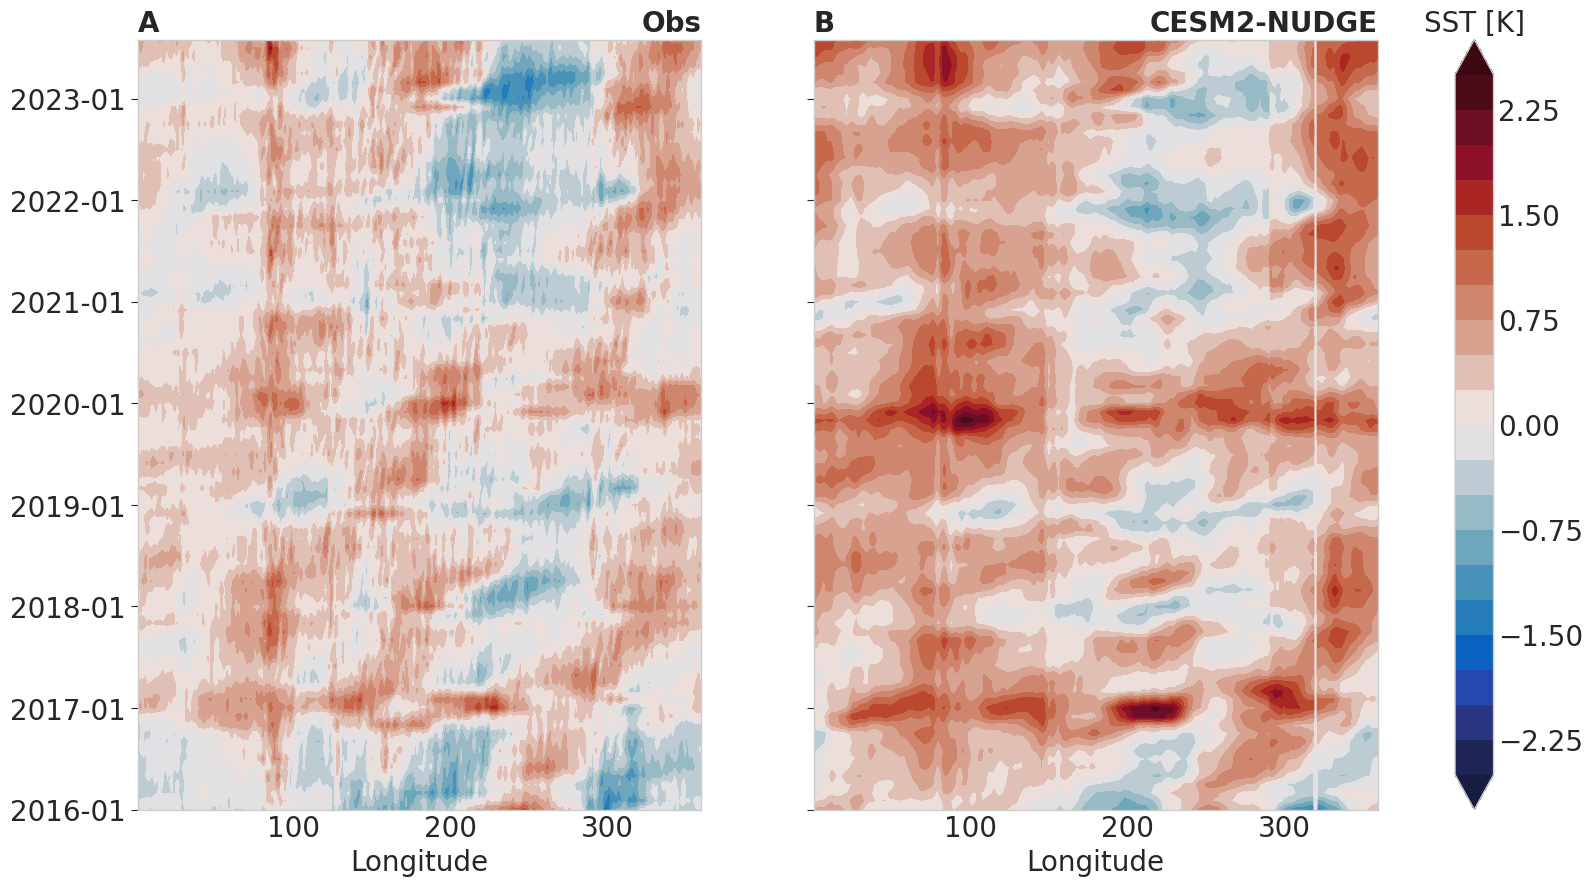

In [87]:
SST_LAT_RANGE = slice(-60, -50)

cmap_info = {
    "cmap": cmocean.cm.balance,
    "levels": np.arange(-2.5, 2.75, .25),
    "units": "SST [K]",
    "step": 12,
    "include_hline": False
}

save_info = {
    "save": True,
    "path": "figures/Figure_SX_Hovmoller-SST.png",
    "dpi": 400,
}

times = np.arange("2016-01", "2023-09", dtype="datetime64[M]")

# Prep Data and Take average of SST over latitudes using cosine weighting
cesm = cesm2_sst_anoms["SST"].sel(time=TIME_RANGE, lat=SST_LAT_RANGE) #.mean(dim="lat")
cesm = cesm.weighted(np.cos(np.deg2rad(cesm.lat))).mean(dim="lat")
obs = era5_atm_anoms["sst"].sel(time=TIME_RANGE, lat=SST_LAT_RANGE) #.mean(dim="lat")
obs = obs.weighted(np.cos(np.deg2rad(obs.lat))).mean(dim="lat") 

create_hovmoller(
    dfs={
        "obs": {
            "data": obs,
            "right_title": "Obs",
            "left_title": "A",
        },
        "cesm": {
            "data": cesm,
            "right_title": "CESM2-NUDGE",
            "left_title": "B",
        }
    }, 
    times=times,
    cmap_info=cmap_info,
    save_info=save_info
)

# Figure SX - Hovmoller Siconc

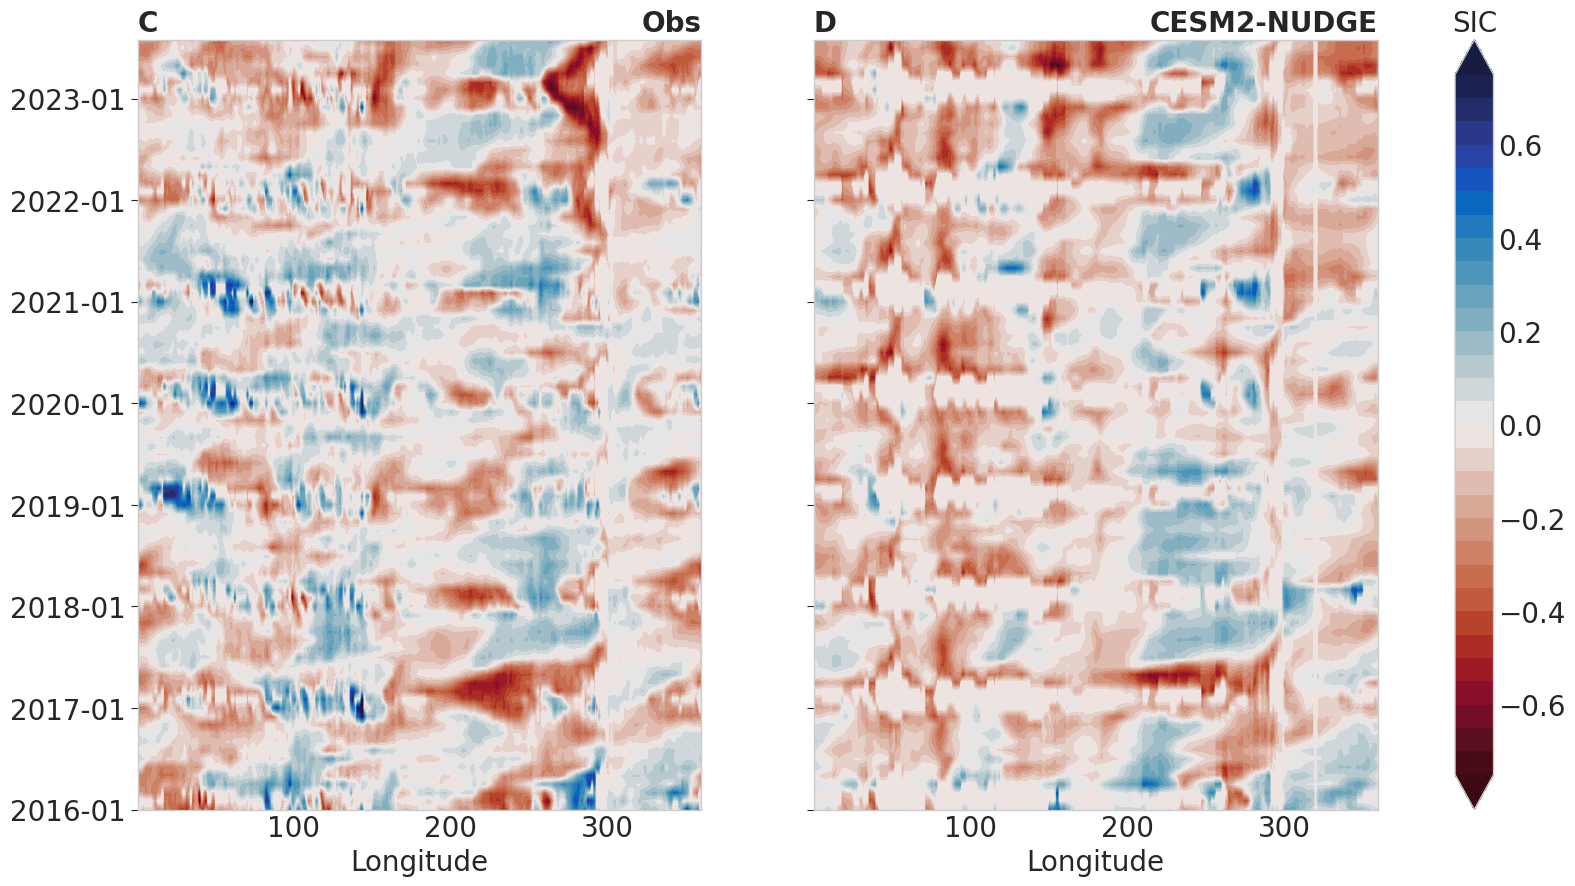

In [88]:
cmap_info = {
    "cmap": cmocean.cm.balance_r,
    "levels": np.arange(-.75, .80, .05),
    # "levels": np.arange(-.25, .26, .01),
    "units": "SIC",
    "step": 12,
    "include_hline": False
}

save_info = {
    "save": True,
    "path": "figures/Figure_SX_Hovmoller-SICONC.png",
    "dpi": 400,
}

# TIME_RANGE = slice("2022-01-01", "2023-08-31")
# times = np.arange("2022-01", "2023-09", dtype="datetime64[M]")

TIME_RANGE = slice("2016-01-01", "2023-08-31")
times = np.arange("2016-01", "2023-09", dtype="datetime64[M]")

cesm2_anoms = cesm2_ice_anoms.sel(time=TIME_RANGE)
obs_anoms = nsidc_ice_anoms.sel(time=TIME_RANGE)


# Prep Data
area_weight_siNSIDC_anoms, _ = get_latitude_ice_edge(
    ice_clim=nsidc_ice_clim["cdr_seaice_conc"],
    ice_anoms=obs_anoms["cdr_seaice_conc"],
    test=False
)
area_weight_siCESM2_anoms, _ = get_latitude_ice_edge(
    ice_clim=cesm2_ice_clim["aice"],
    ice_anoms=cesm2_anoms["aice"],
    test=False,
)

# area_weight_siCESM2_anoms = cesm2_anoms["aice"].sel(lat=slice(-90, -50)).mean(dim="lat")
# area_weight_siNSIDC_anoms = obs_anoms["cdr_seaice_conc"].sel(lat=slice(-90, -50)).mean(dim="lat")


create_hovmoller(
    dfs={
        "obs": {
            "data": area_weight_siNSIDC_anoms,
            "right_title": "Obs",
            "left_title": "C",
        },
        "cesm": {
            "data": area_weight_siCESM2_anoms,
            "right_title": "CESM2-NUDGE",
            "left_title": "D",
        }
    }, 
    times=times,
    cmap_info=cmap_info,
    save_info=save_info
)

# Figure SX - ENSO

/glade/derecho/scratch/zespinosa/tmp/ipykernel_13230/3231394682.py:52: UserWarning: The handle <matplotlib.collections.LineCollection object at 0x7f8c548cce80> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(labels=LEGEND_LABELS, loc='center left', bbox_to_anchor=(1.0, 1.5))
/glade/derecho/scratch/zespinosa/tmp/ipykernel_13230/3231394682.py:52: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8c56ace940> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(labels=LEGEND_LABELS, loc='center left', bbox_to_anchor=(1.0, 1.5))


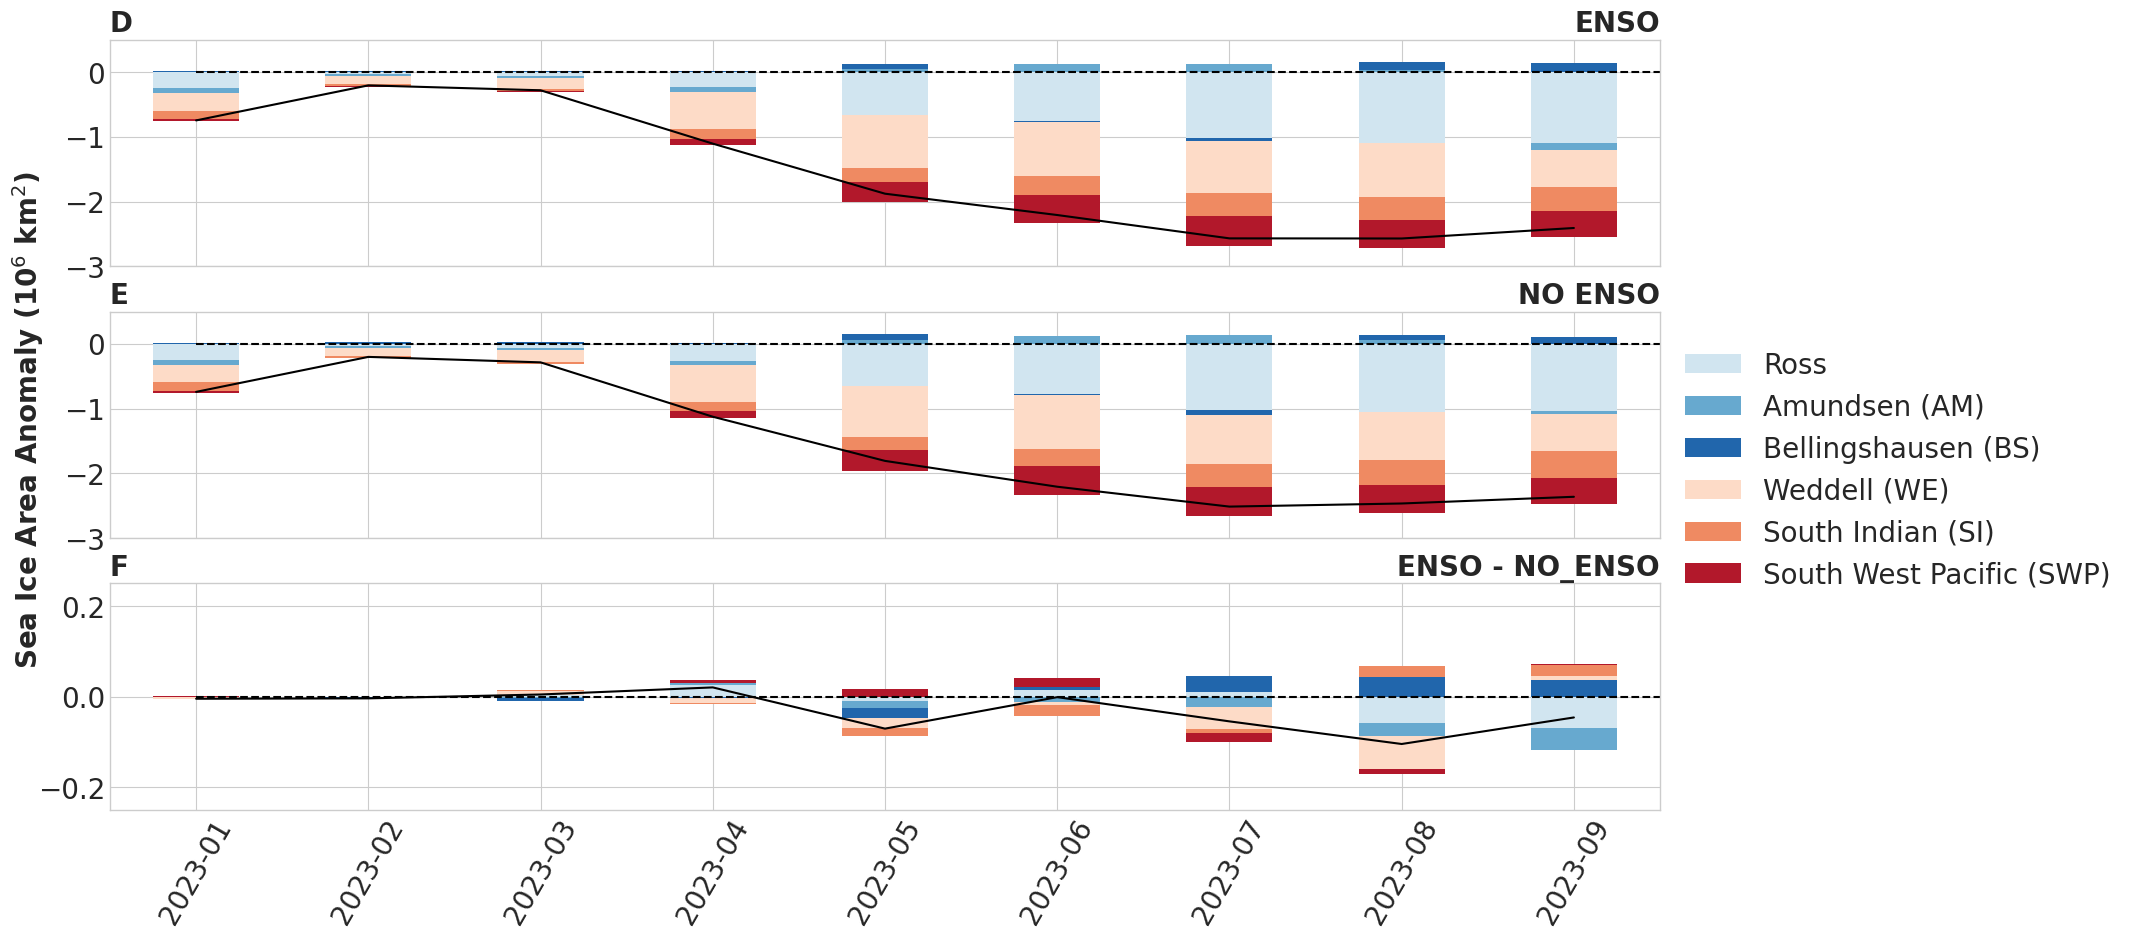

In [100]:
time_params = {
    "time_range": slice("2023-01-15", "2023-09-15"),
    "ticklabels": np.arange("2023-01-15", "2023-10-15", dtype="datetime64[M]"),
}

def timeseries(time_params):
    colors = ['#d1e5f0','#67a9cf','#2166ac', '#fddbc7', '#ef8a62', '#b2182b']
    linewidth = 1.5
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,10), sharex=True)
    # Plot Line for ENSO: CESM2-NUDGE
    sia_cesm2 = si_cesm2[SI_METRIC].sel(time=time_params["time_range"])
    ax1.hlines(0, xmin=0, xmax=len(sia_cesm2), color="black", linewidth=linewidth, linestyle="dashed")
    ax1.plot(sia_cesm2, color="black", linewidth=linewidth)

    # Plot Line for NO ENSO: 
    sia_cesm2_enso = si_cesm2_enso[SI_METRIC].sel(time=time_params["time_range"])
    ax2.hlines(0, xmin=0, xmax=len(sia_cesm2), color="black", linewidth=linewidth, linestyle="dashed")
    ax2.plot(sia_cesm2_enso, color="black", linewidth=linewidth)

    # Plot Line for diff 
    sia_diff = si_cesm2[SI_METRIC].sel(time=time_params["time_range"]) - si_cesm2_enso[SI_METRIC].sel(time=time_params["time_range"])
    ax3.hlines(0, xmin=0, xmax=len(sia_diff), color="black", linewidth=linewidth, linestyle="dashed")
    ax3.plot(sia_diff, color="black", linewidth=linewidth)

    # Plot Bar Charts for CESM2-NUDGE
    sia_regions_cesm2 = si_regions_cesm2[SI_METRIC].sel(time=time_params["time_range"])
    sia_regions_cesm2.to_pandas().T.plot.bar(ax=ax1, stacked=True, legend=False, color=colors)

    sia_regions_cesm2_enso = si_regions_cesm2_enso[SI_METRIC].sel(time=time_params["time_range"])
    sia_regions_cesm2_enso.to_pandas().T.plot.bar(ax=ax2, stacked=True, legend=False, color=colors)

    sia_regions_cesm2_diff = si_regions_cesm2[SI_METRIC].sel(time=time_params["time_range"]) -  si_regions_cesm2_enso[SI_METRIC].sel(time=time_params["time_range"])
    sia_regions_cesm2_diff.to_pandas().T.plot.bar(ax=ax3, stacked=True, legend=False, color=colors)

    # Add Styling
    ax3.set_xticks(np.arange(0, len(sia_cesm2)))
    ax3.set_xticklabels(time_params["ticklabels"], rotation=60)

    ax1.set_title(loc="right", label="ENSO", fontweight="bold")
    ax1.set_title(loc="left", label="D", fontweight="bold")

    ax2.set_title(loc="right", label="NO ENSO", fontweight="bold")
    ax2.set_title(loc="left", label="E", fontweight="bold")

    ax3.set_title(loc="right", label="ENSO - NO_ENSO", fontweight="bold")
    ax3.set_title(loc="left", label="F", fontweight="bold")

    ax1.set_ylim(-3, .5)
    ax2.set_ylim(-3, .5)
    ax3.set_ylim(-.25, .25)

    plt.legend(labels=LEGEND_LABELS, loc='center left', bbox_to_anchor=(1.0, 1.5))
    # Share ylabel for both ax1 and ax2
    fig.text(.075, 0.5, f"{SI_METRIC_LABEL} Anomaly (10$^6$ km$^2$)", va="center", rotation="vertical", fontweight="bold")
    plt.xlabel("")
    plt.savefig("figures/Figure_SX_ENSO.png", dpi=400, bbox_inches='tight')

timeseries(time_params)

# Figure 4: Persistence Forecast

In [101]:
ENSEMBLE_MEMBERS = ["1980", "1985", "1989", "1990", "1993", "1994", "1998", "1999", "2000", "2003", "2004", "2005", "2006", "2007", "2009", "2012", "2013", "2014", "2018", "2020", "2021"]

def load_ensemble(file_name, ens_mems, drop_vars=[], include_year=False):
    """
    Load the processed data files for each ensemble member and return a concatenated dataset.
    """
    ens = []
    for mem in ens_mems: 
        try:
            if include_year:
                path = f"../data/persistence_ensemble/{mem}/{mem}{file_name}"
            else:
                path = f"../data/persistence_ensemble/{mem}/{file_name}"

            cesm2_ens = xr.open_dataset(
                path,
                chunks="auto", 
                drop_variables=drop_vars
            )
            ens.append(cesm2_ens)
        except Exception as e:
            print(f"Could not load {mem}")
            print(e)

    ens = xr.concat(ens, "year")

    return ens

[-0.02497248 -0.23415043  0.01975174  0.08791236  0.05025377  0.14837246
  0.28868499  0.33507693  0.34065487]


/glade/derecho/scratch/zespinosa/tmp/ipykernel_13230/2049153759.py:55: UserWarning: The handle <matplotlib.collections.LineCollection object at 0x7f8c55292490> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(labels=LEGEND_LABELS, loc='center left', bbox_to_anchor=(1.0, 1.5))
/glade/derecho/scratch/zespinosa/tmp/ipykernel_13230/2049153759.py:55: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8c54b985e0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(labels=LEGEND_LABELS, loc='center left', bbox_to_anchor=(1.0, 1.5))


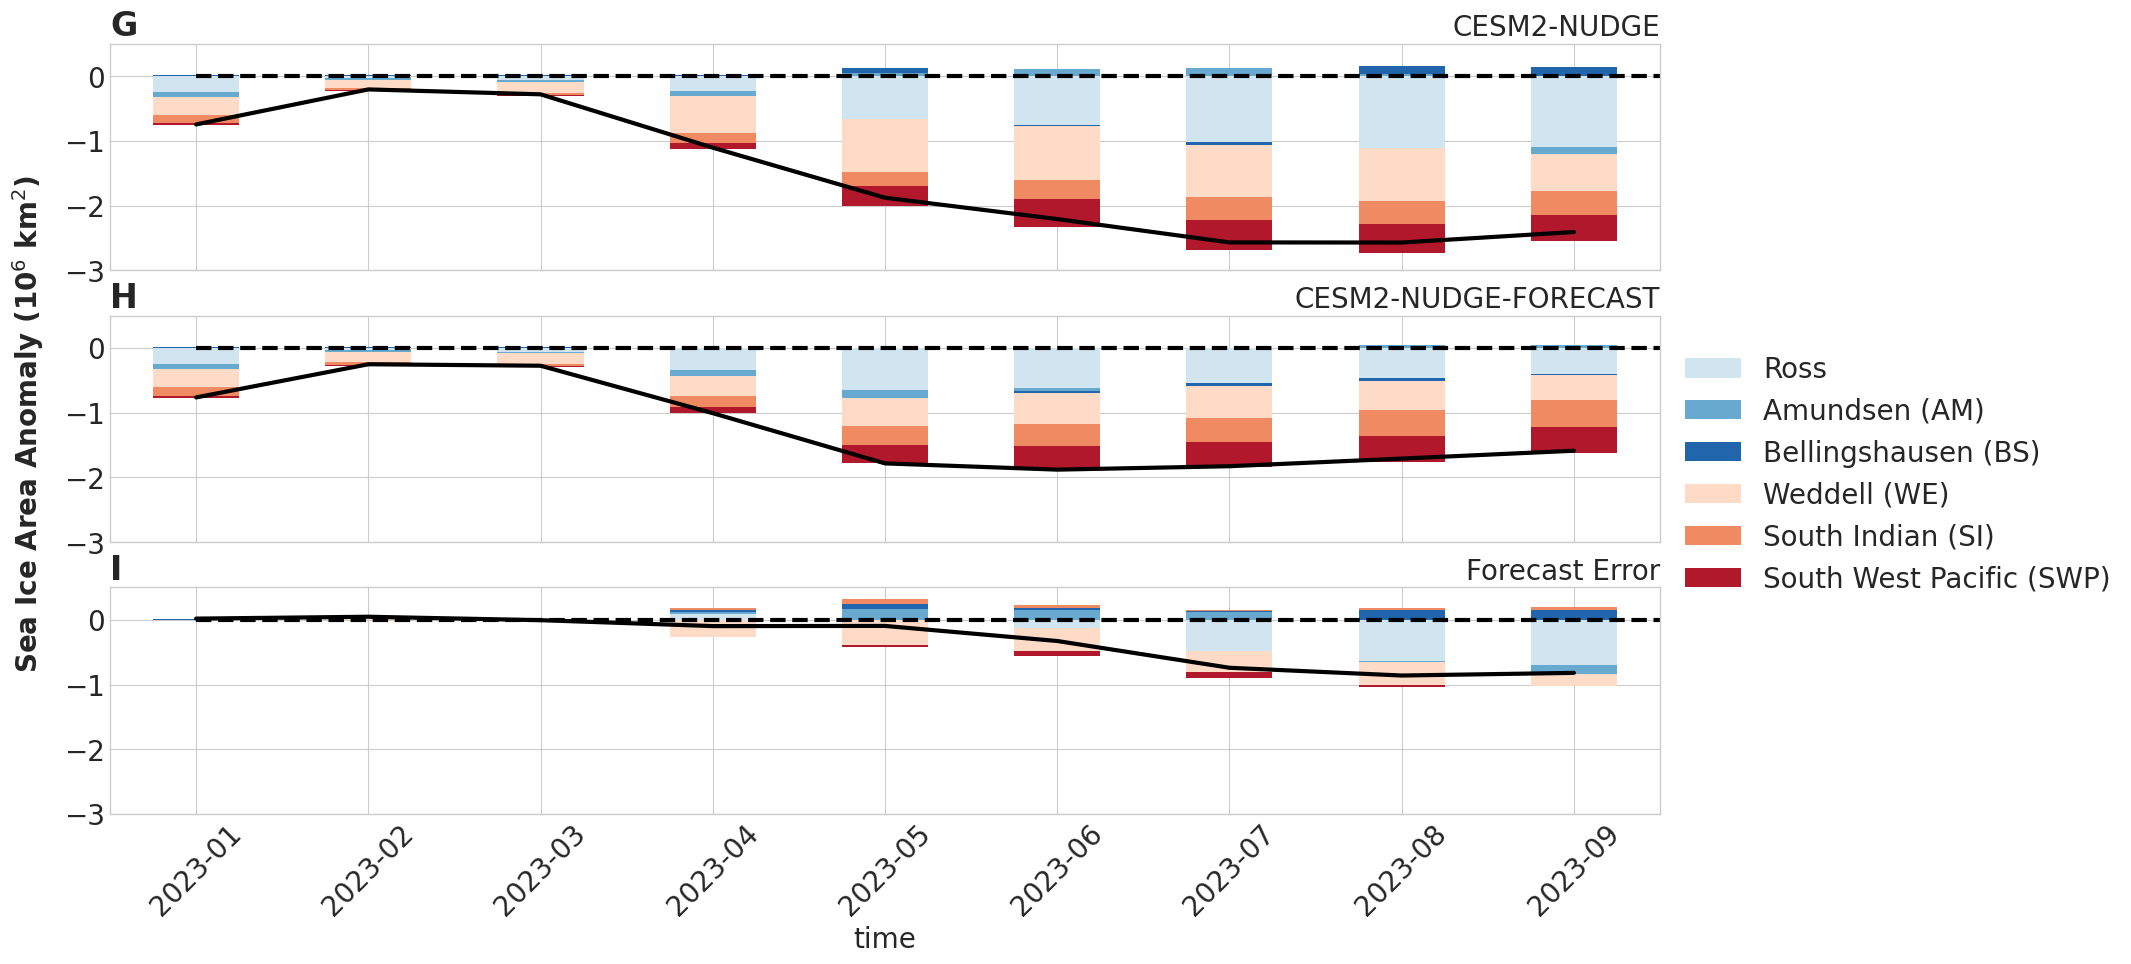

In [103]:
cesm2_ice_ens = load_ensemble(file_name=f"si_CESM_SH_anoms.nc", ens_mems=ENSEMBLE_MEMBERS).mean("year")
cesm2_ice_ens_regions = load_ensemble(file_name=f"si_regions_CESM_anoms.nc", ens_mems=ENSEMBLE_MEMBERS).mean("year")

time_params = {
    "time_range": slice("2023-01-15", "2023-09-15"),
    "ticklabels": np.arange("2023-01-15", "2023-10-15", dtype="datetime64[M]"),
}

def timeseries(time_params):
    colors = ['#d1e5f0','#67a9cf','#2166ac', '#fddbc7', '#ef8a62', '#b2182b']
    linewidth = 3
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,10), sharex=True)
    # Plot Line for CESM2-NUDGE
    sia_cesm2 = si_cesm2[SI_METRIC].sel(time=time_params["time_range"])
    ax1.hlines(0, xmin=0, xmax=len(sia_cesm2), color="black", linewidth=linewidth, linestyle="dashed")
    ax1.plot(sia_cesm2, color="black", linewidth=linewidth)
    # Plot Line for CESM2-NUDGE Forecast 
    sia_cesm2_ens = cesm2_ice_ens[SI_METRIC].sel(time=time_params["time_range"]) 
    ax2.hlines(0, xmin=0, xmax=len(sia_cesm2_ens), color="black", linewidth=linewidth, linestyle="dashed")
    ax2.plot(sia_cesm2_ens, color="black", linewidth=linewidth)
    # Plot Line for diff 
    sia_diff = sia_cesm2 - sia_cesm2_ens
    ax3.hlines(0, xmin=0, xmax=len(sia_diff), color="black", linewidth=linewidth, linestyle="dashed")
    ax3.plot(sia_diff, color="black", linewidth=linewidth)

    # Plot Bar Charts for CESM2-NUDGE
    sia_regions_cesm2 = si_regions_cesm2[SI_METRIC].sel(time=time_params["time_range"])
    sia_regions_cesm2.to_pandas().T.plot.bar(ax=ax1, stacked=True, legend=False, color=colors)
    # Plot Bar Charts for CESM2-NUDGE Forecast
    sia_regions_cesm2_ens = cesm2_ice_ens_regions[SI_METRIC].sel(time=time_params["time_range"]) 
    sia_regions_cesm2_ens.to_pandas().T.plot.bar(ax=ax2, stacked=True, legend=False, color=colors)
    # Plot Bar Charts for diff
    sia_regions_cesm2_diff = sia_regions_cesm2 - sia_regions_cesm2_ens
    sia_regions_cesm2_diff.to_pandas().T.plot.bar(ax=ax3, stacked=True, legend=False, color=colors)

    print((sia_diff / sia_cesm2).values)
    # Add Styling
    ax3.set_xticks(np.arange(0, len(sia_cesm2)))
    ax3.set_xticklabels(time_params["ticklabels"], rotation=45)

    ax1.set_title(loc="right", label="CESM2-NUDGE")
    ax1.set_title(loc="left", label="G", fontweight="bold", fontsize=24)

    ax2.set_title(loc="right", label="CESM2-NUDGE-FORECAST")
    ax2.set_title(loc="left", label="H", fontweight="bold", fontsize=24)

    ax3.set_title(loc="right", label="Forecast Error")
    ax3.set_title(loc="left", label="I", fontweight="bold", fontsize=24)

    ax1.set_ylim(-3, .5)
    ax2.set_ylim(-3, .5)
    ax3.set_ylim(-3, .5)

    fig.text(.075, 0.5, f"{SI_METRIC_LABEL} Anomaly (10$^6$ km$^2$)", va="center", rotation="vertical", fontweight="bold")
    plt.legend(labels=LEGEND_LABELS, loc='center left', bbox_to_anchor=(1.0, 1.5))
    plt.savefig("figures/Figure_SX_Persistence.png", dpi=400, bbox_inches='tight')

timeseries(time_params)

# Figure SX - Ensemble Spread

In [92]:
cesm2_ice_ens = load_ensemble(file_name=f"si_CESM_SH_anoms.nc", ens_mems=ENSEMBLE_MEMBERS)
cesm2_ice_ens_regions = load_ensemble(file_name=f"si_regions_CESM_anoms.nc", ens_mems=ENSEMBLE_MEMBERS)

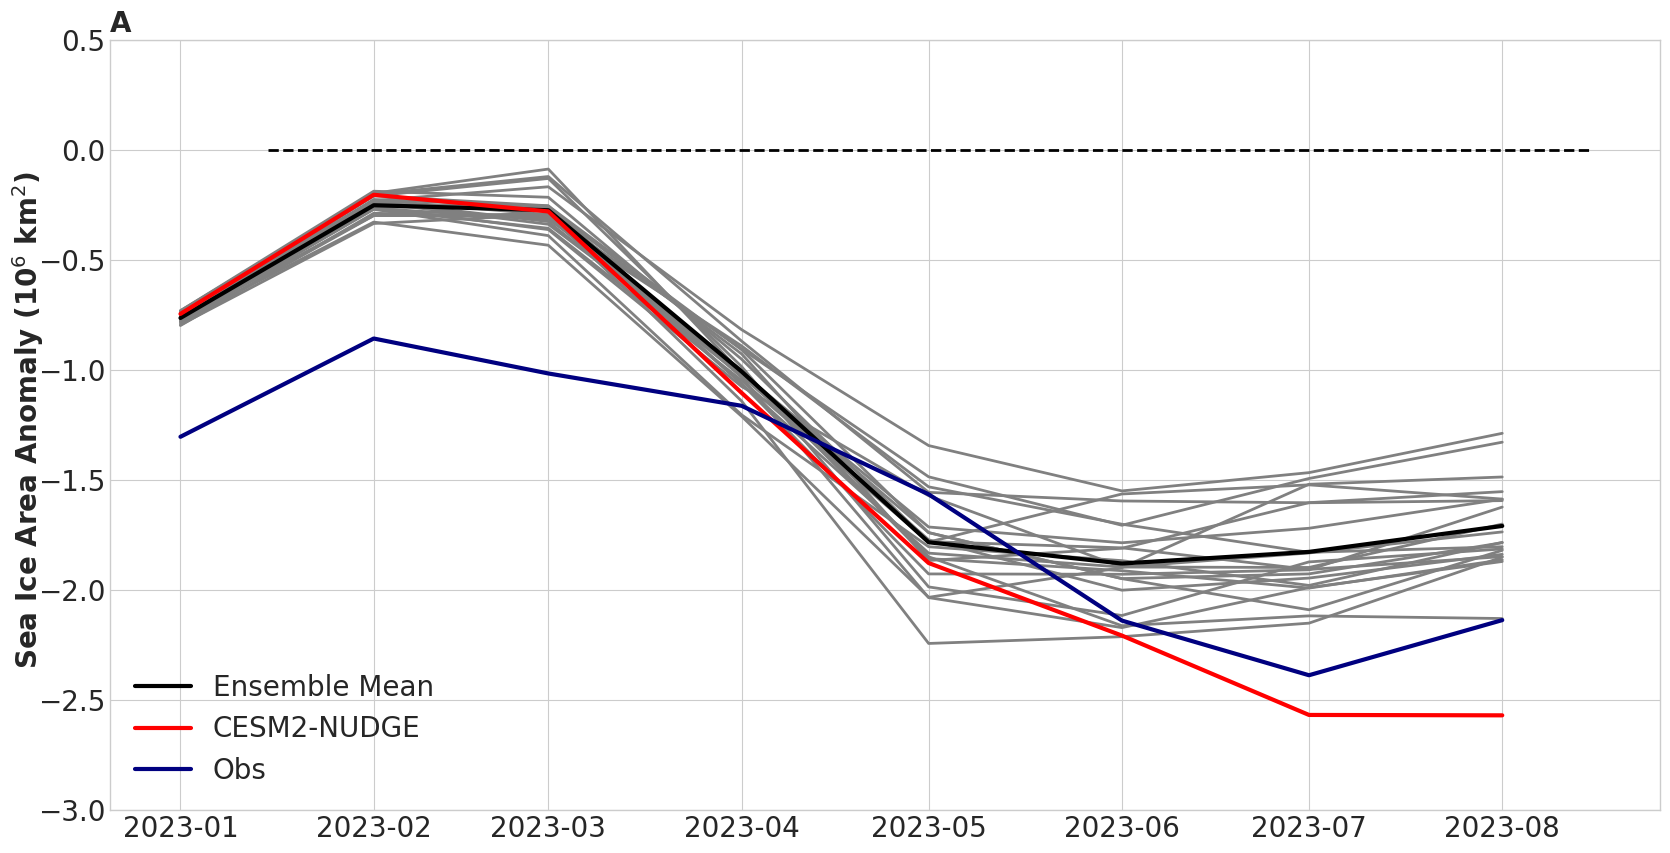

In [93]:
def plot_ensemble_spread(save_name):
    fig, ax = plt.subplots(1, 1, figsize=(20,10), sharex=True)

    time = np.arange("2023-01-01", "2023-09-01", dtype="datetime64[M]")

    for i, mem in enumerate(ENSEMBLE_MEMBERS):
        s = cesm2_ice_ens[SI_METRIC].sel(time=slice("2023-01-15", "2023-08-15")).isel(year=i)
        ax.plot(time, s, linewidth=2, color="gray", linestyle="solid")

    ens_mean = cesm2_ice_ens[SI_METRIC].sel(time=slice("2023-01-15", "2023-08-15")).mean('year')
    ax.plot(time, ens_mean, linewidth=3, color="black", linestyle="solid", label="Ensemble Mean")

    # Horizontal Line
    ax.hlines(0, xmin=s.time[0], xmax=s.time[-1], color="black", linewidth=2, linestyle="dashed")

    # Plot CESM2-NUDGE
    si_cesm2_c = si_cesm2[SI_METRIC].sel(time=slice("2023-01-15", "2023-08-15"))
    ax.plot(time, si_cesm2_c, linewidth=3, color="red", linestyle="solid", label="CESM2-NUDGE")

    # Plot NSIDC
    si_nsidc_c = si_nsidc[SI_METRIC].sel(time=slice("2023-01-01", "2023-08-01"))
    ax.plot(time, si_nsidc_c, linewidth=3, color="navy", linestyle="solid", label="Obs")

    ax.set_yticks(np.arange(-3, 1, .5))
    fig.text(.075, 0.5, f"{SI_METRIC_LABEL} Anomaly (10$^6$ km$^2$)", va="center", rotation="vertical", fontweight="bold")

    ax.set_ylim(-3, .5) 
    ax.legend(loc='lower left')
    ax.set_title("A", loc="left", fontweight="bold")
    plt.savefig(f"figures/Figure_SX_{save_name}.png", dpi=400)
    

plot_ensemble_spread(save_name="Ensemble_Spread")

# Figure SX - Meridional Winds and Sea Ice Anomalies

In [94]:
SEASON = 'QS-DEC'
SEASON_TIME = "2023-06"
TIME_RANGE = slice("2016-01-01", "2023-08-31")
times = np.arange("2016-01", "2023-09", dtype="datetime64[M]")

cesm2_anoms = cesm2_ice_anoms.sel(time=TIME_RANGE)
obs_anoms = nsidc_ice_anoms.sel(time=TIME_RANGE)

def interpolate_seaice_gap(ds):
    """
    There is an issue in the sea ice data at longitude 319.5 and 320.5 (indices 319 and 320).
    This function fills the gap by taking linear interpolation between the two points on 
    either side of the gap (indices 318 and 321).
    """
    ds[:,:, 319] = ds[:,:, 318] + (ds[:,:, 321] - ds[:,:, 318])/3
    ds[:,:, 320] = ds[:,:, 318] + (ds[:,:, 321] - ds[:,:, 318])*2/3
    return ds

# Get the ice edge and sea ice concentration area weight anomalies for CESM2-NUDGE and NSIDC
area_weight_siNSIDC_anoms, ice_edge_nsidc = get_latitude_ice_edge(
    ice_clim=nsidc_ice_clim["cdr_seaice_conc"],
    ice_anoms=obs_anoms["cdr_seaice_conc"],
    test=False
)
area_weight_siCESM2_anoms, ice_edge_cesm2 = get_latitude_ice_edge(
    ice_clim=interpolate_seaice_gap(cesm2_ice_clim["aice"]),
    ice_anoms=interpolate_seaice_gap(cesm2_anoms["aice"]),
    test=False,
)

# Resample to seasonal and select 2023 JJA
aice_cesm2 = area_weight_siCESM2_anoms.resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
ice_edge_cesm2 = ice_edge_cesm2.resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()

aice_nsidc = area_weight_siNSIDC_anoms.resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
ice_edge_nsidc = ice_edge_nsidc.resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()

In [95]:
# Get Meridional Winds at 10m for CESM2-NUDGE and ERA5 in JJA
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

era5_v10 = era5_atm_anoms["v10"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
cesm2_v10 = cesm2_atm_anoms["V"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()

cesm2_v10_at_ice_edge = cesm2_v10.sel(lat=ice_edge_cesm2, method="nearest").isel(lev=0).squeeze()
era5_v10_at_ice_edge = era5_v10.sel(lat=ice_edge_nsidc, method="nearest").squeeze()

In [97]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

def plot_winds_anoms(aice, v10, title, save_name):
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    # Horizontal Line
    ax.hlines(0, xmin=aice.lon[0], xmax=aice.lon[-1], color="black", linewidth=2, linestyle="dashed")
    ax.plot(aice.lon, aice, label="CESM2-NUDGE", color="black")

    ax1 = ax.twinx()
    ax1.plot(v10.lon, v10, color="red")
    # Set x and y labels
    ax.set_xlabel("Longitude", fontweight="bold")
    fig.text(.070, 0.5, f"{SI_METRIC_LABEL} Anomaly (10$^6$ km$^2$)", va="center", rotation="vertical", fontweight="bold")
    fig.text(.95, 0.5, f"10m Meridional Winds at Ice Edge", va="center", rotation=-90, fontweight="bold", color="red")
    # Set color of yticks
    ax1.tick_params(axis='y', colors='red')
    ax1.set_ylim(-5, 3.5)
    ax.set_ylim(-.6, .4)
    ax.set_title(title[0], loc="left", fontweight="bold")
    ax.set_title(title[1], loc="right", fontweight="bold")
    align_yaxis(ax, 0, ax1, 0)
    plt.savefig(f"figures/Figure_SX_{save_name}.png", dpi=400)

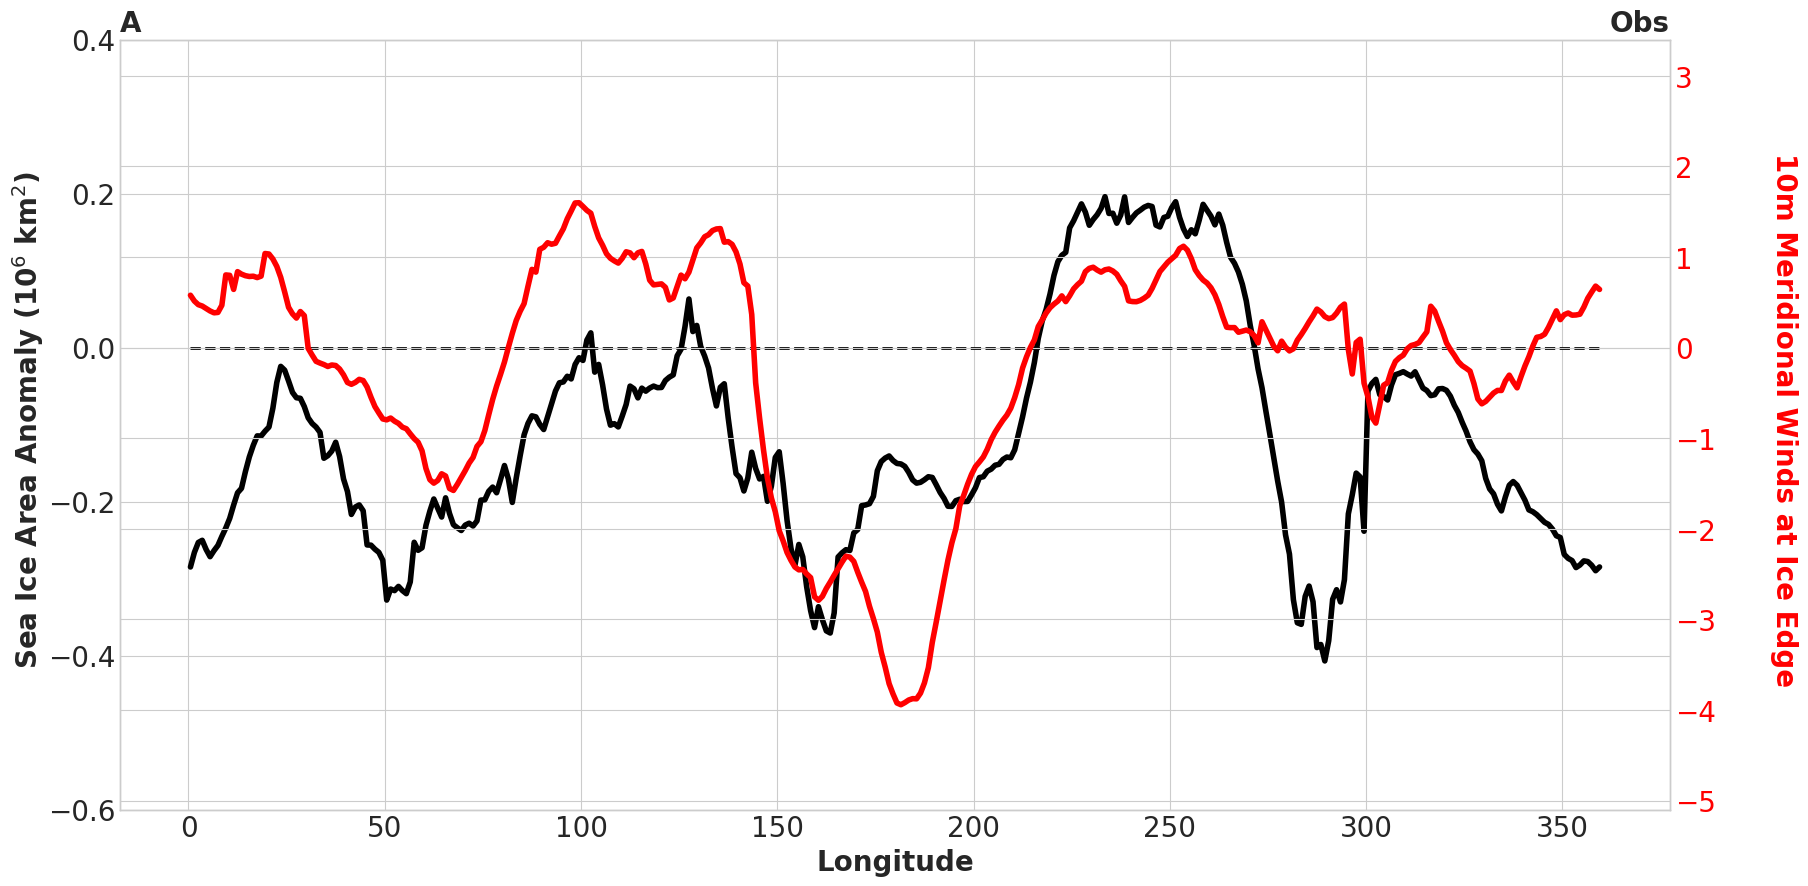

In [98]:
plot_winds_anoms(
    aice=aice_nsidc,
    v10=era5_v10_at_ice_edge,
    title=("A", "Obs"),
    save_name="nsidc_v10_ice"
)

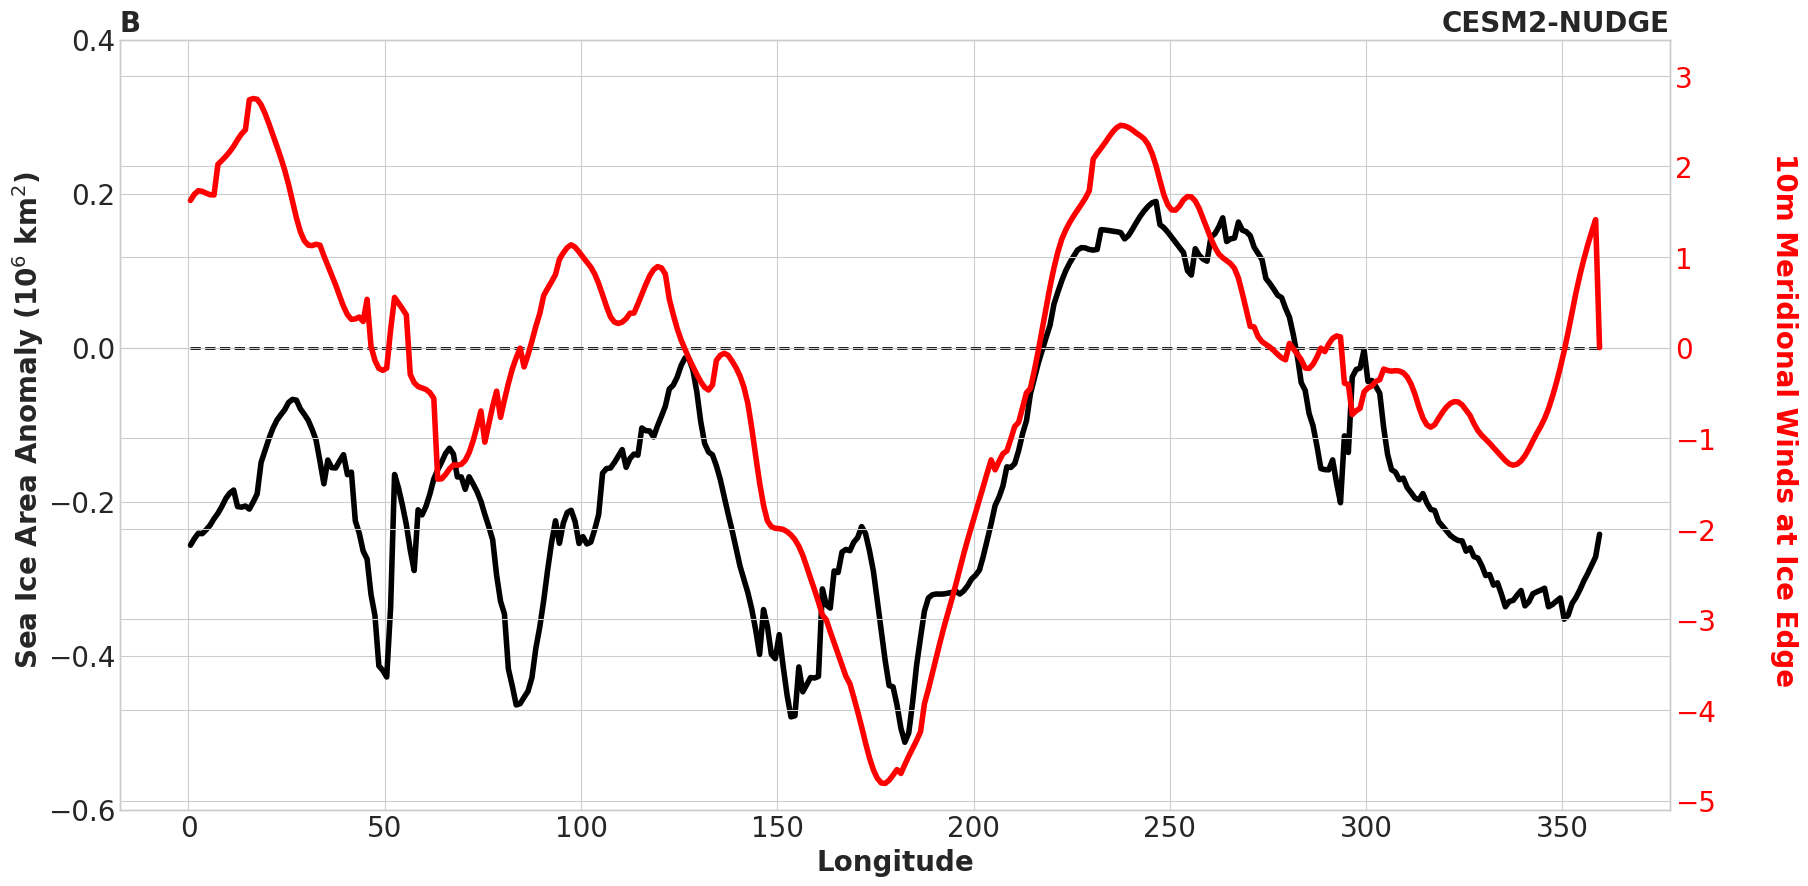

In [99]:
plot_winds_anoms(
    aice=aice_cesm2,
    v10=cesm2_v10_at_ice_edge,
    title=("B", "CESM2-NUDGE"),
    save_name="cesm2_v10_ice"
)

# Figure SX - Hovmoller of Ensemble Mean SST and SICONC

In [132]:
cesm2_sst_ens_anoms = load_ensemble(file_name=f"_cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc", ens_mems=ENSEMBLE_MEMBERS, include_year=True).mean("year")
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")

In [140]:
# Prep Data
cesm = cesm2_sst_anoms["SST"].sel(time=TIME_RANGE, lat=SST_LAT_RANGE).mean(dim="lat")
cesm_ens = cesm2_sst_ens_anoms["SST"].sel(time=TIME_RANGE, lat=SST_LAT_RANGE).mean(dim="lat")
# Add cosine weighting


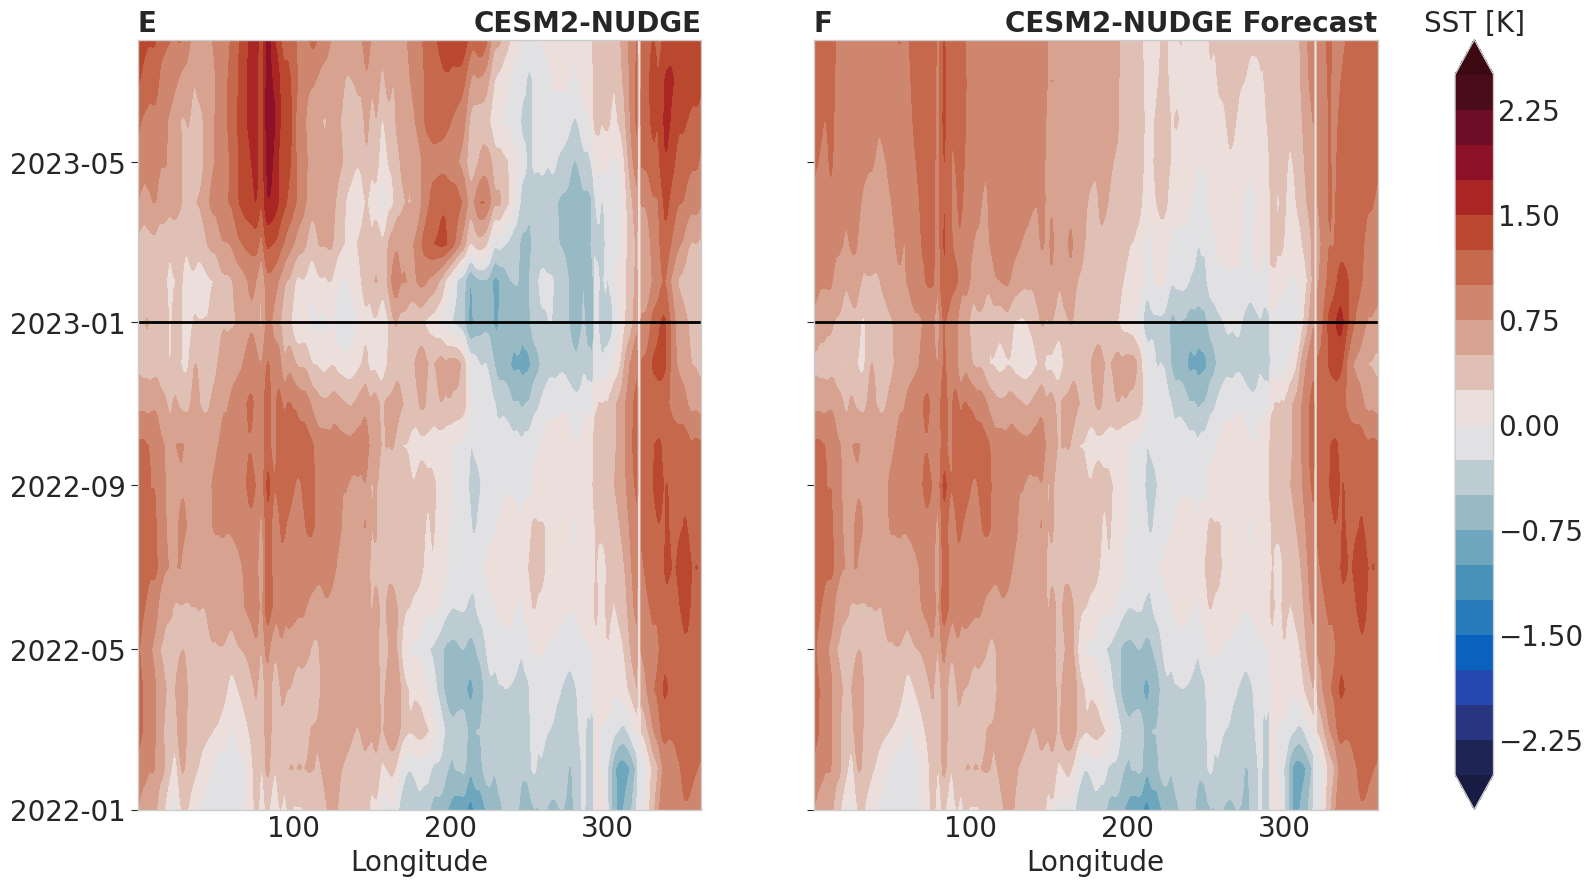

In [159]:
SST_LAT_RANGE = slice(-60, -50)

cmap_info = {
    "cmap": cmocean.cm.balance,
    "levels": np.arange(-2.5, 2.75, .25),
    "units": "SST [K]",
}

save_info = {
    "save": True,
    "path": "figures/Figure_SX_Ens-Hovmoller-SST.png",
    "dpi": 400,
}
times = np.arange("2022-01", "2023-10", dtype="datetime64[M]")

TIME_RANGE = slice("2021-12-01", "2023-08-31")

# Prep Data
cesm = cesm2_sst_anoms["SST"].sel(time=TIME_RANGE, lat=SST_LAT_RANGE)
cesm_ens = cesm2_sst_ens_anoms["SST"].sel(time=TIME_RANGE, lat=SST_LAT_RANGE)

cesm = cesm.weighted(np.cos(np.deg2rad(cesm.lat))).mean(dim="lat")
cesm_ens = cesm_ens.weighted(np.cos(np.deg2rad(cesm_ens.lat))).mean(dim="lat")


create_hovmoller(
    dfs={
        "obs": { # THIS IS NOT OBS - IT'S CESM2-NUDGE
            "data": cesm,
            "right_title": "CESM2-NUDGE",
            "left_title": "E",
        },
        "cesm": {
            "data": cesm_ens,
            "right_title": "CESM2-NUDGE Forecast",
            "left_title": "F",
        }
    }, 
    times=times,
    cmap_info=cmap_info,
    save_info=save_info
)

# Figure SX - Subsurface

In [4]:
ds_subsurf = xr.open_dataset('../data/cesm2_ocn-subsurface_T_monthly_1950-01_2023-12-anoms.nc')
ds_subsurf

<xarray.Dataset>
Dimensions:  (time: 552, z_t: 40, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2024-12-15
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    TEMP     (time, z_t, lat, lon) float64 ...
    HMXL     (time, lat, lon) float64 ...
Attributes:
    title:             cesm2.1.3_BHISTcmip6_f09_g17_ERA5_nudge
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-10-15 at 09:31:46.9
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [9]:
SEASON = 'QS-DEC'
SEASON_TIME = "2023-06"

# SO 60S-50S Plot Depth vs Longitude
ds_subsurf_SO = ds_subsurf.sel(lat=slice(-60, -50)).mean(dim="lat").resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
# ds_subsurf_SO["TEMP"].plot()
# SO Plot Depth vs Latitude  
ds_subsurf_SO_lat = ds_subsurf.sel(lat=slice(-70, -40)).mean(dim="lon").resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
ds_subsurf_SO_lat["TEMP"].plot()

# Climate Indices

In [104]:
sys.path.insert(0, "/glade/work/zespinosa/Projects/climate-utils")
from utils import (
    from_pickle, 
    to_pickle, 
    xarray_time_to_monthly,
    xarray_monthly_to_time,
    get_season,
)

def read_csv(ds, fp, len_header): 
    index = []
    with open(fp, newline='') as csvfile:
        csvf = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for i, row in enumerate(csvf):
            if i < len_header: continue
            if i == len_header: 
                header = row[0].split(',')
                continue
                
            ds[i-(len_header+1), :] = row[0].split(',')[1:]
            index.append(row[0].split(',')[0])
    
    ds = pd.DataFrame(data=ds, index=np.array(index), columns=header[1:])
    return ds
        
def read_txt(ds, fp, len_header, fill=-99.99):
    """
    Read arbitrary text file with header and data delineated with a space
    """
    nyrs, nmons = ds.shape
    years = []
    
    with open(fp) as f:
        lines = f.readlines()
        for n, line in enumerate(lines):
            if n < len_header: continue # skip header
            if n >= (nyrs+len_header): break # skip footer
            
            cidx = line.split()
            years.append(int(cidx[0]))
            ds[n-len_header, :] = cidx[1:]
            
    ds = xr.DataArray(
        data=ds,
        dims=["year", "month"],
        coords=dict(year=years, month=np.arange(1, 1+nmons))
    )
    ds = ds.where(fill, np.nan)

    return ds


ROOT = "/glade/work/zespinosa/data/index/"

# Load IPO, SAM, NINO 3.4
ipo = read_txt(np.zeros((2024 - 1854, 12)), os.path.join(ROOT, "IPO-TPI_NOAA-ERSSTV5_185401-202312_monthly.txt"), len_header=2)
nino34 = read_txt(np.zeros((2024 - 1948, 12)), os.path.join(ROOT, "ENSO", "Nino34_194801-202309_anoms.txt"), len_header=2)
sam_marshall = read_txt(np.zeros((2024 - 1957, 12)), os.path.join(ROOT, "SAM", "SAM_Marshall-195701-202311_monthly.txt"), len_header=4)

# Load ASL index
asl = read_csv(np.zeros((538, 5)), os.path.join(ROOT, "ASL/amundsen-sea-low-index/v3/era5", "asli_monthly_v3.20210820-era5-197901-202312.csv"), len_header=26)
asl = xr.DataArray(asl, dims=['time', 'index']) #.sel(index="ActCenPres")
asl["time"] = np.array(asl.time.values, dtype="datetime64[M]")
# asl.sel(index="ActCenPres")

In [105]:
# Prep IPO
ipo_flat = xarray_monthly_to_time(ipo)
ipo_flat = ipo_flat.sel(time=TIME_RANGE)
# Prep NINO 3.4
nino34_flat = xarray_monthly_to_time(nino34)
nino34_flat = nino34_flat.sel(time=TIME_RANGE)
nino34_flat = nino34_flat.where(nino34_flat != -99.99, np.nan) # fill -99.99 with nan
# Prep SAM
sam_flat = xarray_monthly_to_time(sam_marshall)
sam_flat = sam_flat.sel(time=TIME_RANGE)

In [116]:
# Standardize Each Term
idx = "RelCenPres"
asl_z = (asl.sel(index=idx) - asl.sel(index=idx).mean()) / asl.sel(index=idx).std()
ipo_z = (ipo_flat - ipo_flat.mean())/ ipo_flat.std()
nino34_z = (nino34_flat - nino34_flat.mean())/ nino34_flat.std()
sam_z = (sam_flat - sam_flat.mean())/ sam_flat.std()

In [125]:
def get_mv_pred():
    import statsmodels.api as sm

    X = np.column_stack((asl_z, ipo_z, nino34_z, sam_z))
    X = sm.add_constant(X)
    X = X[:-2, :]

    Y = si_nsidc["sia"]
    Y[107] = np.nan
    Y[108] = np.nan
    Y = (Y - Y.mean()) / Y.std()

    X = X[~np.isnan(Y), :]
    Y = Y[~np.isnan(Y)]
    time = Y.time
    Y = Y.to_numpy()

    # METHOD ONE
    model = sm.OLS(Y, X)
    results = model.fit()
    sm_pred = results.predict()

    # METHOD TWO
    from sklearn import linear_model
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    sklean_pred = regr.predict(X)

    return sm_pred, Y, time

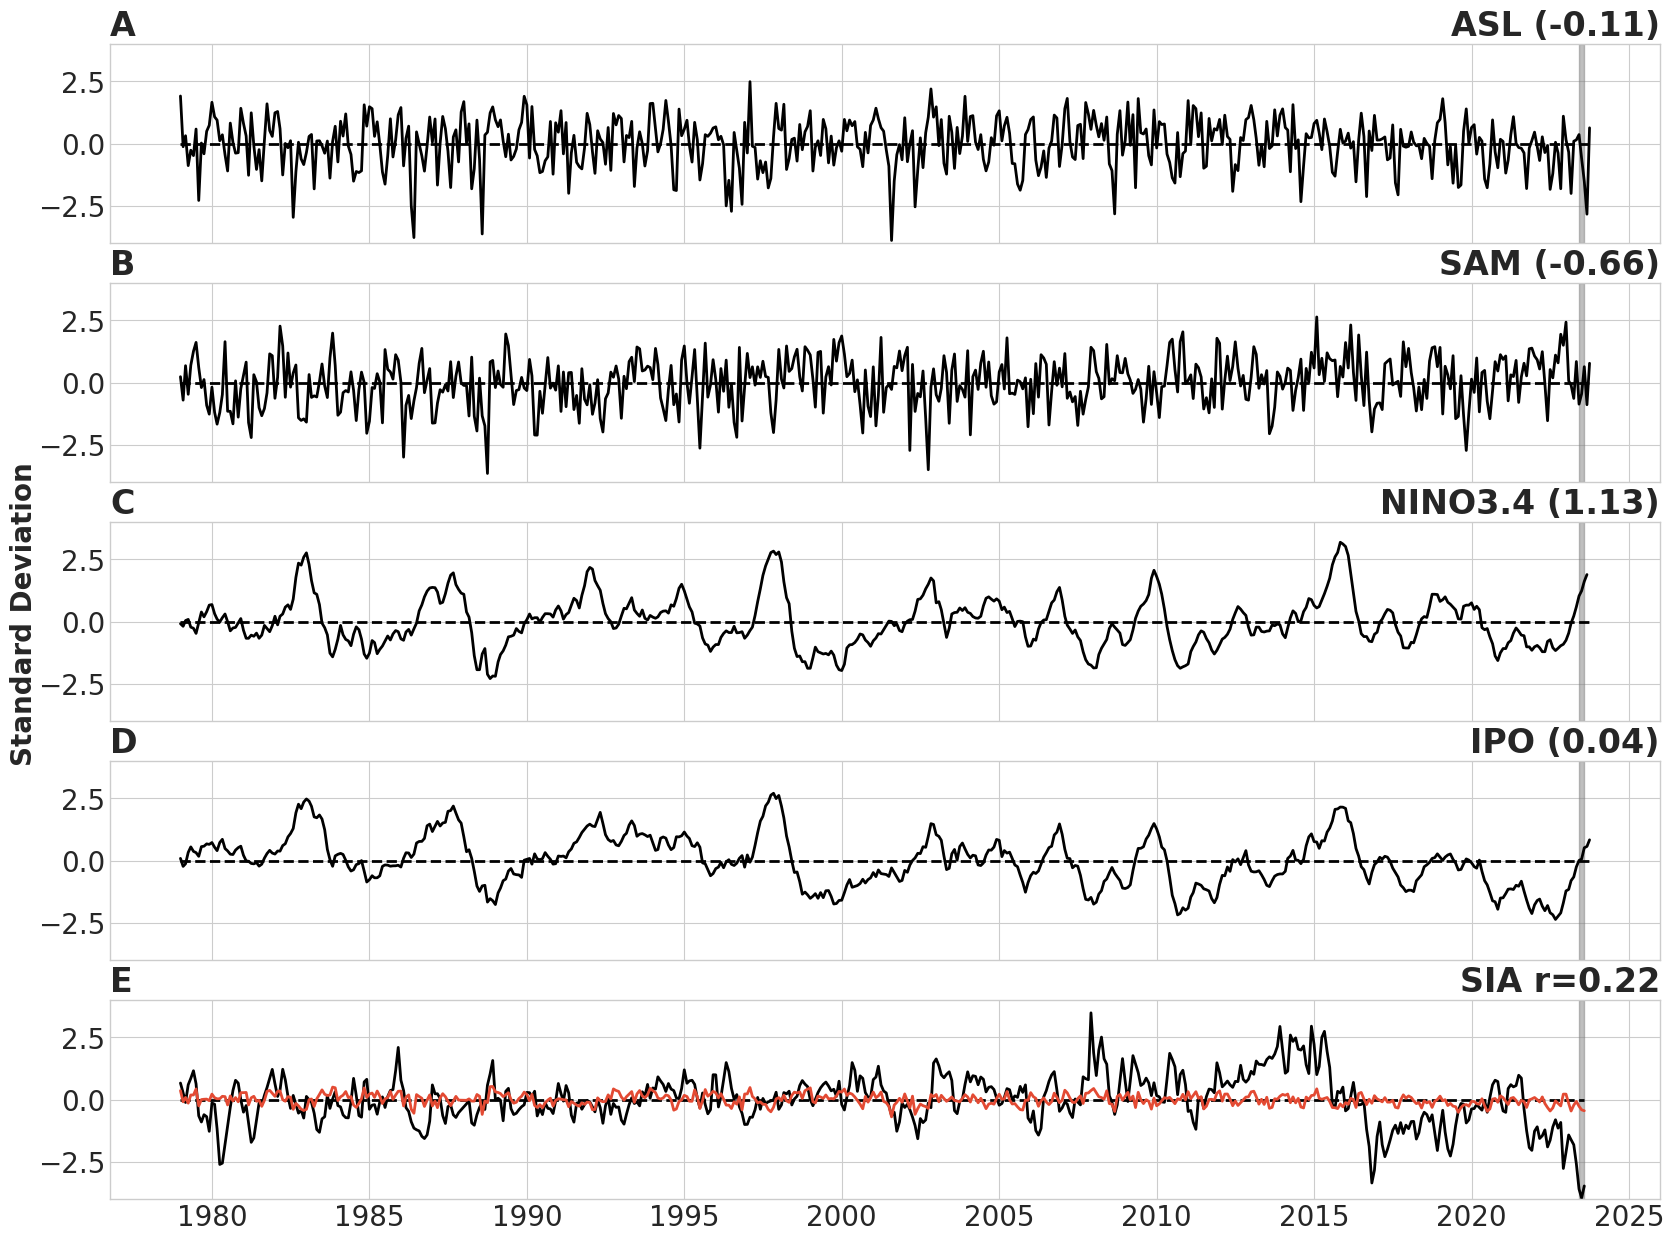

In [128]:
TIME_RANGE = slice("1979-01", "2023-10")

def plot_indicies(indices, time):
        title_fontsize = 24
        
        fig, axs = plt.subplots(5, 1, figsize=(20,15), sharex=True)

        # Add Horizontal Lines
        labels = ["A", "B", "C", "D", "E"]
        for i, ax in enumerate(axs):
            if i == 4: 
                ctime = indices["Regression"][-1]
            else: 
                ctime = time
            ax.hlines(0, xmin=ctime[0], xmax=ctime[-1], color="black", linewidth=2, linestyle="dashed")
            ax.axvspan("2023-06", "2023-08", color="gray", alpha=.5)
            ax.set_ylim(-4, 4)
            ax.set_title(loc="left", label=labels[i], fontweight="bold", fontsize=title_fontsize)

        # Plot ASL
        axs[0].plot(time, indices["ASL"], color="black", linewidth=2)

        # Plot SAM
        axs[1].plot(time, indices["SAM"], color="black", linewidth=2)

        # Plot NINO34
        axs[2].plot(time, indices["NINO34"], color="black", linewidth=2)

        # Plot IPO
        axs[3].plot(time, indices["IPO"], color="black", linewidth=2)

        axs[4].plot(indices["Regression"][-1], indices["Regression"][1], color="black", label="Obs", linewidth=2)
        axs[4].plot(indices["Regression"][-1], indices["Regression"][0], color=colors[1], label="Prediction", linewidth=2)
        reg = linregress(indices["Regression"][1], indices["Regression"][0])
        rvalue = np.around(reg.rvalue, 2)


        # Add AX specific info
        s = list(asl.time.values).index(np.datetime64("2023-06-01"))
        asl_mean = indices["ASL"][s:s+2].mean().values.round(2)
        sam_mean = indices["SAM"][s:s+2].mean().values.round(2)
        nino34_mean = indices["NINO34"][s:s+2].mean().values.round(2)
        ipo_mean = indices["IPO"][s:s+2].mean().values.round(2)

        axs[0].set_title(loc="right", label=f"ASL ({asl_mean})", fontweight="bold", fontsize=title_fontsize)
        axs[1].set_title(loc="right", label=f"SAM ({sam_mean})", fontweight="bold", fontsize=title_fontsize)
        axs[2].set_title(loc="right", label=f"NINO3.4 ({nino34_mean})", fontweight="bold", fontsize=title_fontsize)
        axs[3].set_title(loc="right", label=f"IPO ({ipo_mean})", fontweight="bold", fontsize=title_fontsize)
        axs[4].set_title(loc="right", label=f"SIA r={rvalue}", fontweight="bold", fontsize=title_fontsize)

        # Share ylabel for both ax1 and ax2
        fig.text(.075, 0.5, "Standard Deviation", va="center", rotation="vertical", fontweight="bold")

        # save figure
        # plt.savefig("figures/Figure_SX_Indices.png", dpi=400)

Y_pred, Y, time = get_mv_pred()

plot_indicies(
    indices={
        "ASL": asl_z,
        "IPO": ipo_z,
        "NINO34": nino34_z,
        "SAM": sam_z,
        "Regression": (Y_pred, Y, time)
    },
    time=asl.time
)